In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
import seaborn as sns
from scipy import stats
from astropy.table import Table
import warnings
from astropy.utils.exceptions import AstropyWarning
import itertools
np.seterr(all='ignore')
warnings.simplefilter('ignore', category=AstropyWarning)
plt.style.use('dark_background')
plt.rcParams.update({'figure.facecolor':'#16191C'})
plt.rcParams.update({'axes.facecolor':'#16191C'})
%matplotlib notebook
sns.set_color_codes(palette='colorblind')

First, read in data. Let's take the Pantheon SN Ia dataset (Scolnic et al. 2018), with over 1000 SNe Ia

In [3]:
def rewrite_mass_columns(df,mass_cn,err_cn,pm=False):
    '''A function to '''
    df.rename(columns={mass_cn:'logm',err_cn:'logm_err'},inplace=True)
    if pm:
        df['logm_err'] = np.abs(df['logm']-df['logm_err'])
    df['detection'] = pd.Series((df['logm_err']>0),index=df.index)
    return df

In [4]:
pantheon = pd.read_csv('/media/data3/wiseman/des/hosts/ps1_s18.dat',sep = ' ',skipinitialspace=True)
pantheon = pantheon[pantheon['HOST_LOGMASS']>5.01]
pantheon = rewrite_mass_columns(pantheon,'HOST_LOGMASS','HOST_LOGMASS_ERR')


In [5]:
# define some convenience functions to make a CDF and draw some uncertainties on it
def make_cdf(arr):
    sorted_arr = np.sort(arr)
    cumsum = np.cumsum(sorted_arr)
    cumsum /=cumsum[-1]
    return sorted_arr,cumsum

def perturb_arr_normal(vals,lowerrs,upperrs):
    peturbed = np.random.normal(vals,np.mean([lowerrs,upperrs]))
    return peturbed
def plot_hist(x,lo,hi,step,axhist,weights = [],density=False,**kwargs):
    
    bins = np.linspace(lo,hi,int((hi-lo)/step),endpoint=False)
    bin_centers = (bins [:-1] + bins [1:])/2
    frac_obj = []
    n_obj = []
    frac_errs = []
    bw = bins[-1] - bins[-2]
    for counter,bl in enumerate(bins[:-1]):
        if len(weights)>0:
            n_in_bin = np.sum(weights[(x>bl)&(x<=bl+(bw))])
        else: 
            n_in_bin = len(x[(x>bl)&(x<=bl+(bw))])
        frac_obj.append(n_in_bin/len(x))
        n_obj.append(n_in_bin)
        frac_errs.append(np.sqrt(n_in_bin)/len(x))
    if density:
        axhist.step(bin_centers,frac_obj/bw,linewidth=2,where='mid',**kwargs)
    else:
        axhist.step(bin_centers,n_obj/bw,linewidth=2,where='mid',**kwargs)


<IPython.core.display.Javascript object>


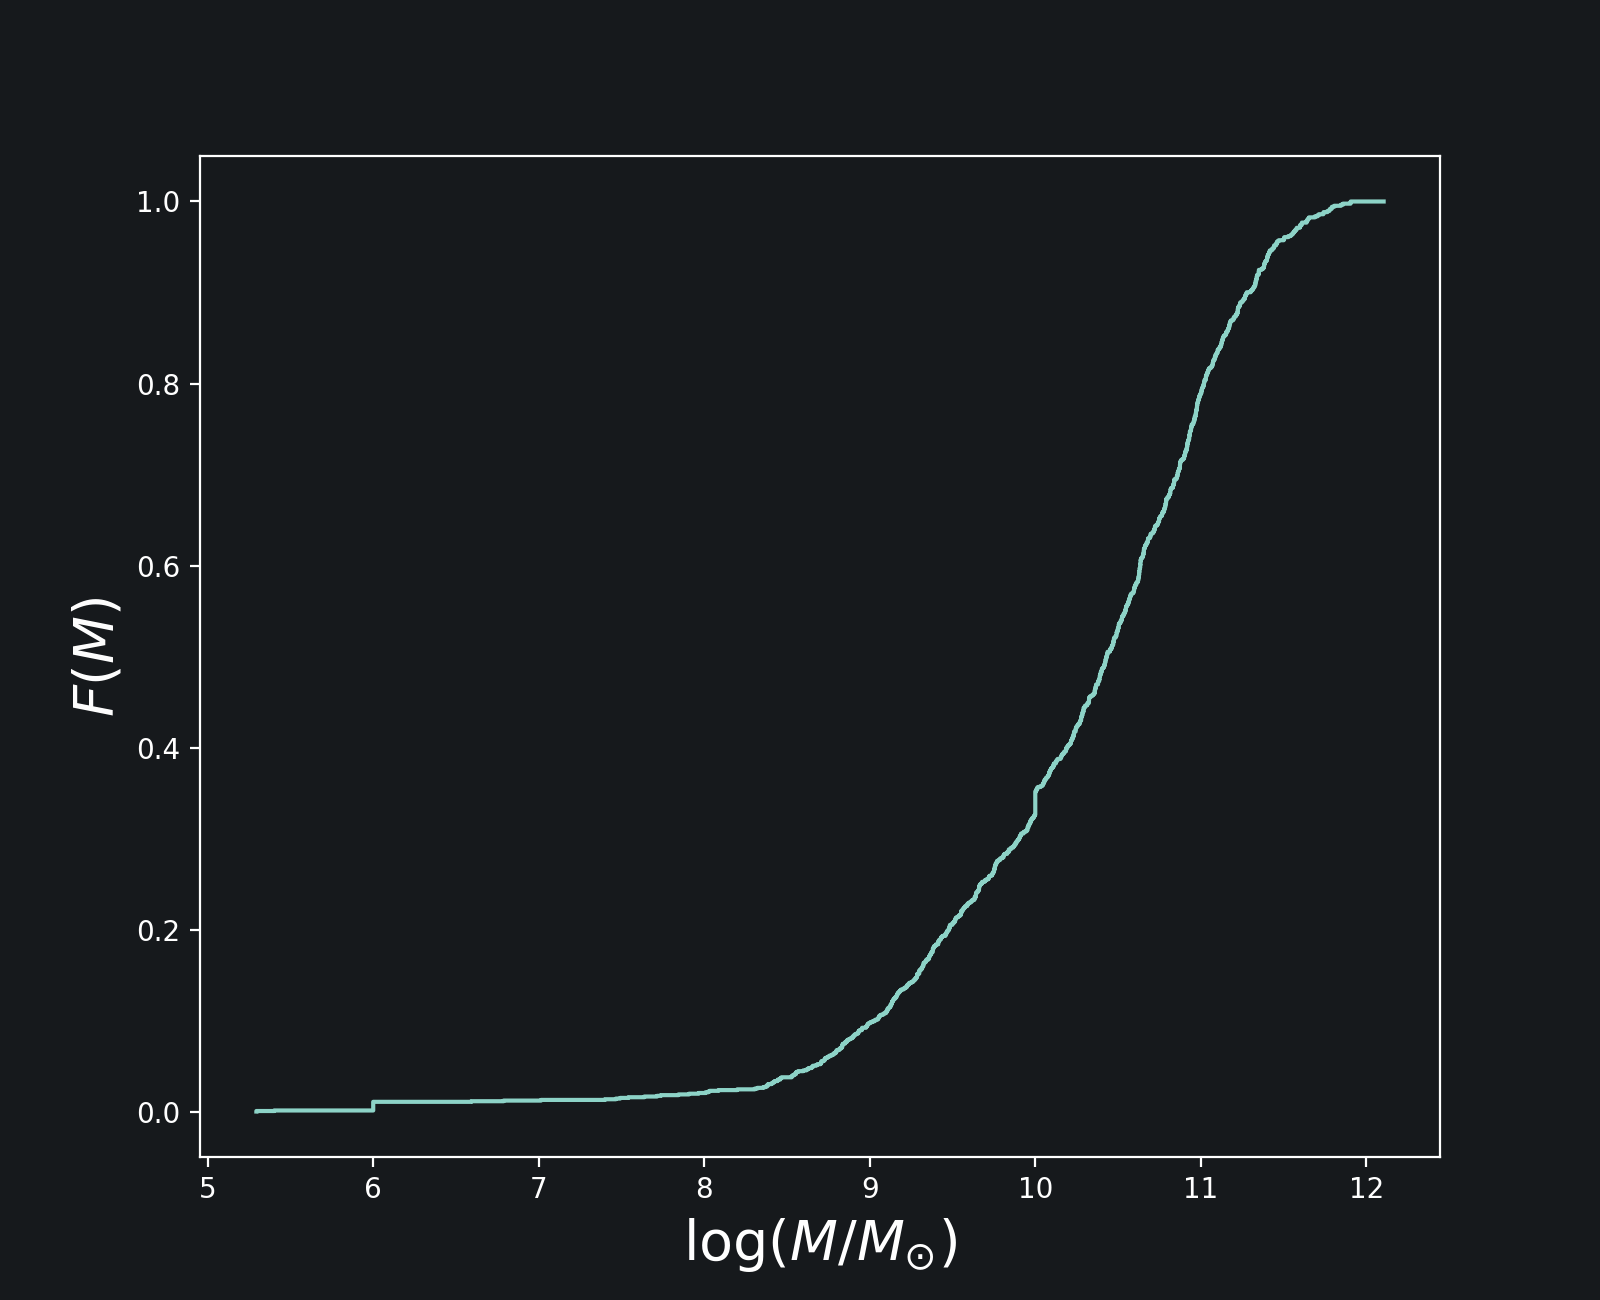

Text(0, 0.5, '$F(M)$')

In [6]:
f,ax=plt.subplots(figsize=(8,6.5))
sorted_ms,cdf = make_cdf(pantheon['logm'])
ax.step(sorted_ms,cdf,label='Pantheon SNe')
ax.set_xlabel('$\log (M/M_{\odot})$',size=20)
ax.set_ylabel('$F(M)$',size=20)

So this CDF looks fairly standard, with a long low-mass tail -- I bet these aren't real galaxies (No SNe explode in galaxies with log M < 7, there aren't enough stars. Anyway, we'll save that for later. For now, let's do some sample comparisons. Let's split the data up by their stretch parameter, x1, which is known to correlate with mass (e.g. Sullivan et al. 2010)

<IPython.core.display.Javascript object>


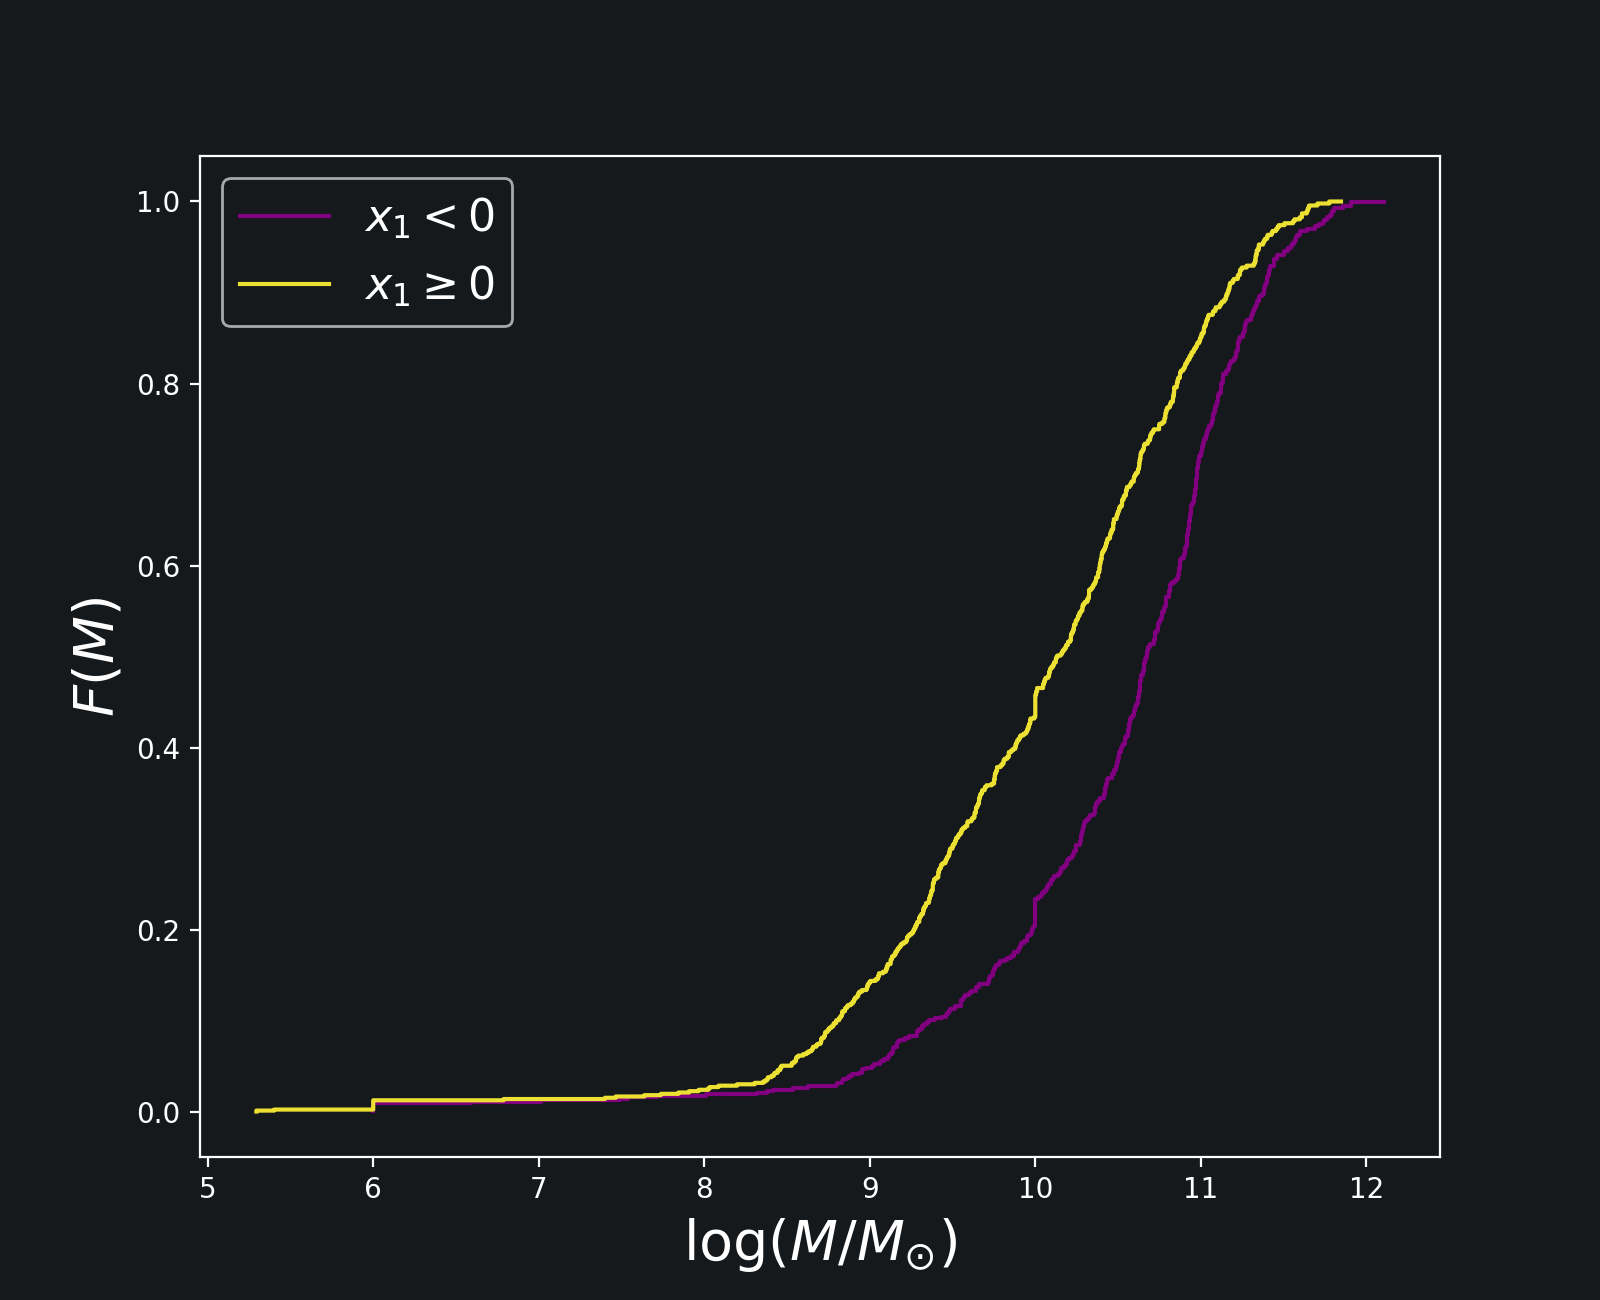

In [7]:
import itertools 
stretch_cond = pantheon['x1']<0
low_stretch_SNe = pantheon[stretch_cond]
high_stretch_SNe = pantheon[~stretch_cond]
colours = itertools.cycle(['purple','y'])
f,ax=plt.subplots(figsize=(8,6.5))
for SNe,sample_name in zip([low_stretch_SNe,high_stretch_SNe],['$x_1 <0$','$x_1\geq0$']):
    sorted_ms,cdf = make_cdf(SNe['logm'])
    ax.step(sorted_ms,cdf,label=sample_name,c=next(colours))
ax.set_xlabel('$\log (M/M_{\odot})$',size=20)
ax.set_ylabel('$F(M)$',size=20)
ax.legend(loc='upper left',fontsize=16)

The low stretch SNe are clearly shifted to higher mass than the high-stretch objects. Usually, people would just do a KS test and be done with it. So let's do that...

In [8]:
stats.ks_2samp(low_stretch_SNe.logm,high_stretch_SNe.logm)

KstestResult(statistic=0.2780124941320911, pvalue=1.6527576345946424e-17)

The p-value is tiny; we'd say that these samples are unambiguously drawn from different parent distributions. But, we've made a lot of assumptions -- How do we know that the objects don't have a mass uncertainty that's larger than their differences? What about the x1 split, how many objects are on the wrong side and could that change things? 

First, let's resample from the mass uncertainties and reestimate the CDF

<IPython.core.display.Javascript object>


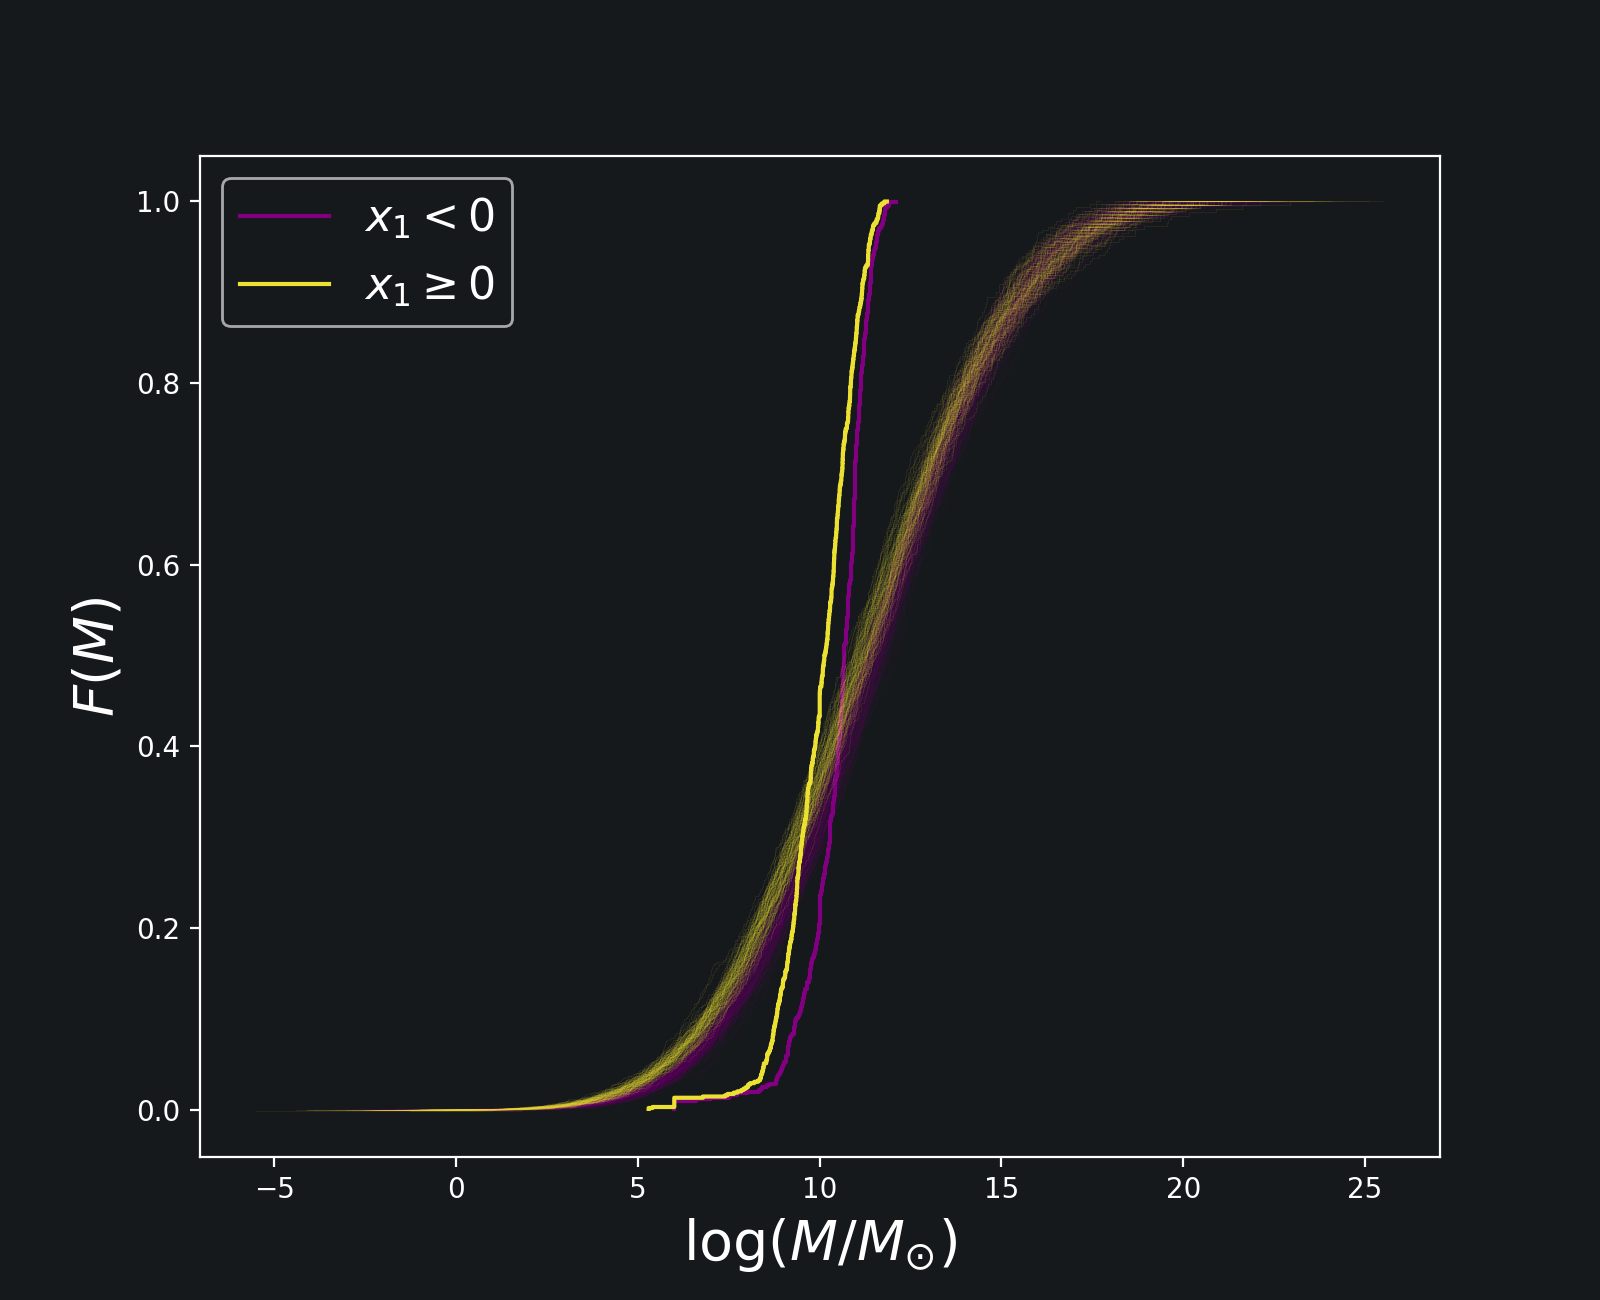

In [9]:
f,ax=plt.subplots(figsize=(8,6.5))
for SNe,sample_name in zip([low_stretch_SNe,high_stretch_SNe],['$x_1 <0$','$x_1\geq0$']):
    sorted_ms,cdf = make_cdf(SNe['logm'])
    c = next(colours)
    ax.step(sorted_ms,cdf,label=sample_name,color=c)
    for i in range(100):
        perturbed = perturb_arr_normal(SNe['logm'],SNe['logm_err'],SNe['logm_err'])
        sorted_ms,cdf = make_cdf(perturbed)
        ax.step(sorted_ms,cdf,linewidth=0.025,color=c)
ax.set_xlabel('$\log (M/M_{\odot})$',size=20)
ax.set_ylabel('$F(M)$',size=20)
ax.legend(loc='upper left',fontsize=16)

# Uh-oh!
The estimated CDFs from resampled data are being dragged out to unphysical low and high masses due to some poorly constrained uncertainties -- our CDF is being entirely driven by the errors

In [10]:
#Let's see if there are some ridiculous errors
pantheon['logm_err'].max()

99.0

In [11]:
len(pantheon[pantheon['logm_err']==99])

26

In [12]:
len(pantheon[pantheon['logm_err']>1])

111

Wow. 111 objects have a mass uncertainty greater than 1 order of magnitude. The errors that are 99 are clearly meant to be "non detections". That's basically saying we have no idea -- there could be 10^9 stars, but also 10^11. Resampling from these broad distributions is completely smearing out our CDF. How should we deal with this? Let's get rid of them first, and see what happens.

<IPython.core.display.Javascript object>


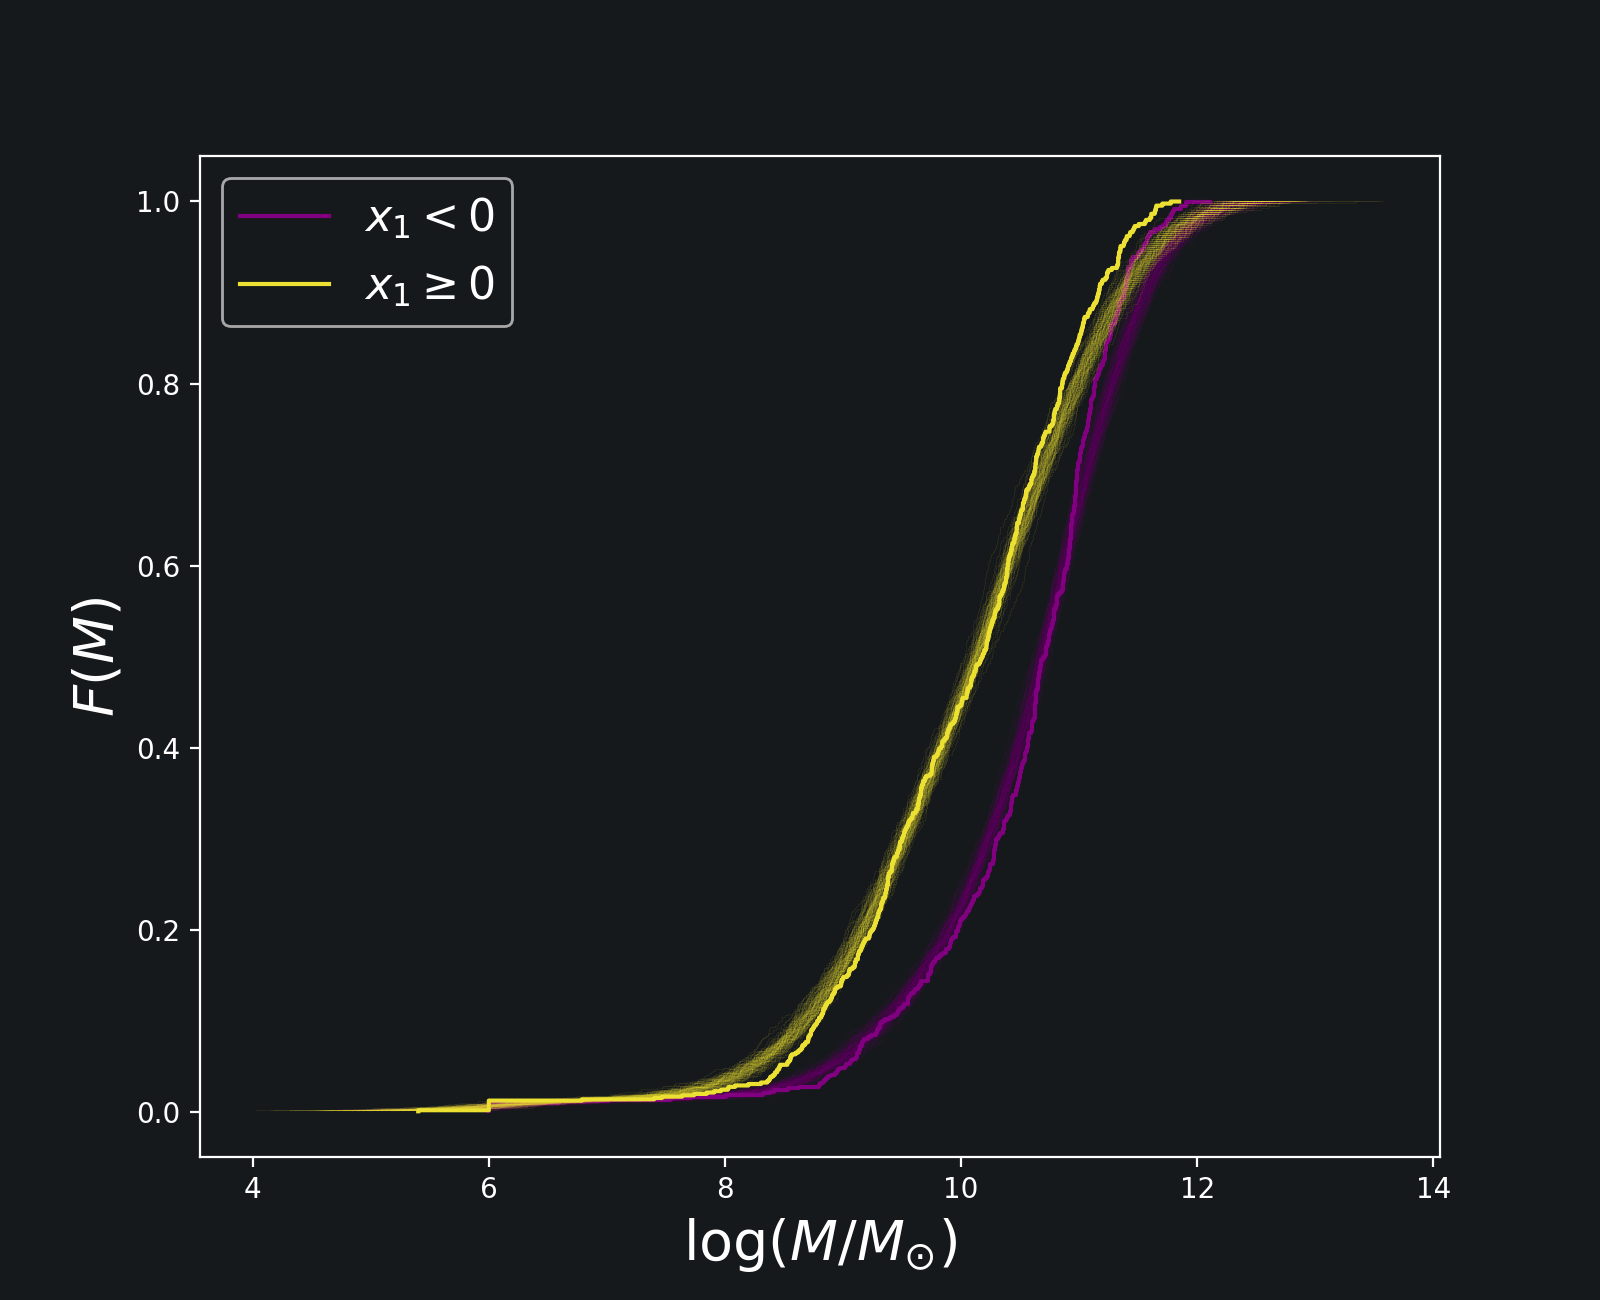

In [13]:
colours = itertools.cycle(['purple','y'])
f,ax=plt.subplots(figsize=(8,6.5))
for SNe,sample_name in zip([low_stretch_SNe,high_stretch_SNe],['$x_1 <0$','$x_1\geq0$']):
    SNe = SNe[SNe['logm_err']<10]
    sorted_ms,cdf = make_cdf(SNe['logm'])
    c = next(colours)
    ax.step(sorted_ms,cdf,label=sample_name,color=c)
    for i in range(100):
        perturbed = perturb_arr_normal(SNe['logm'],SNe['logm_err'],SNe['logm_err'])
        sorted_ms,cdf = make_cdf(perturbed)
        ax.step(sorted_ms,cdf,linewidth=0.025,color=c)
ax.set_xlabel('$\log (M/M_{\odot})$',size=20)
ax.set_ylabel('$F(M)$',size=20)
ax.legend(loc='upper left',fontsize=16)

We're still a bit off. What's most interesting is what is happening at low and high masses - the CDF is getting blurred a bit. This is because the resampling will always act to pull a few of the high mass objects even higher, and a few of the low mass objects even lower. So maybe this is giving us a better estimate of the _true_ CDF compared to the noisy one given by the point estimates of the data.

Pantheon is a compilation of various surveys, each with their own host stellar mass estimation techniques. It appears that some defaulted to different logm_err values if the mass was poorly constrained:

<IPython.core.display.Javascript object>


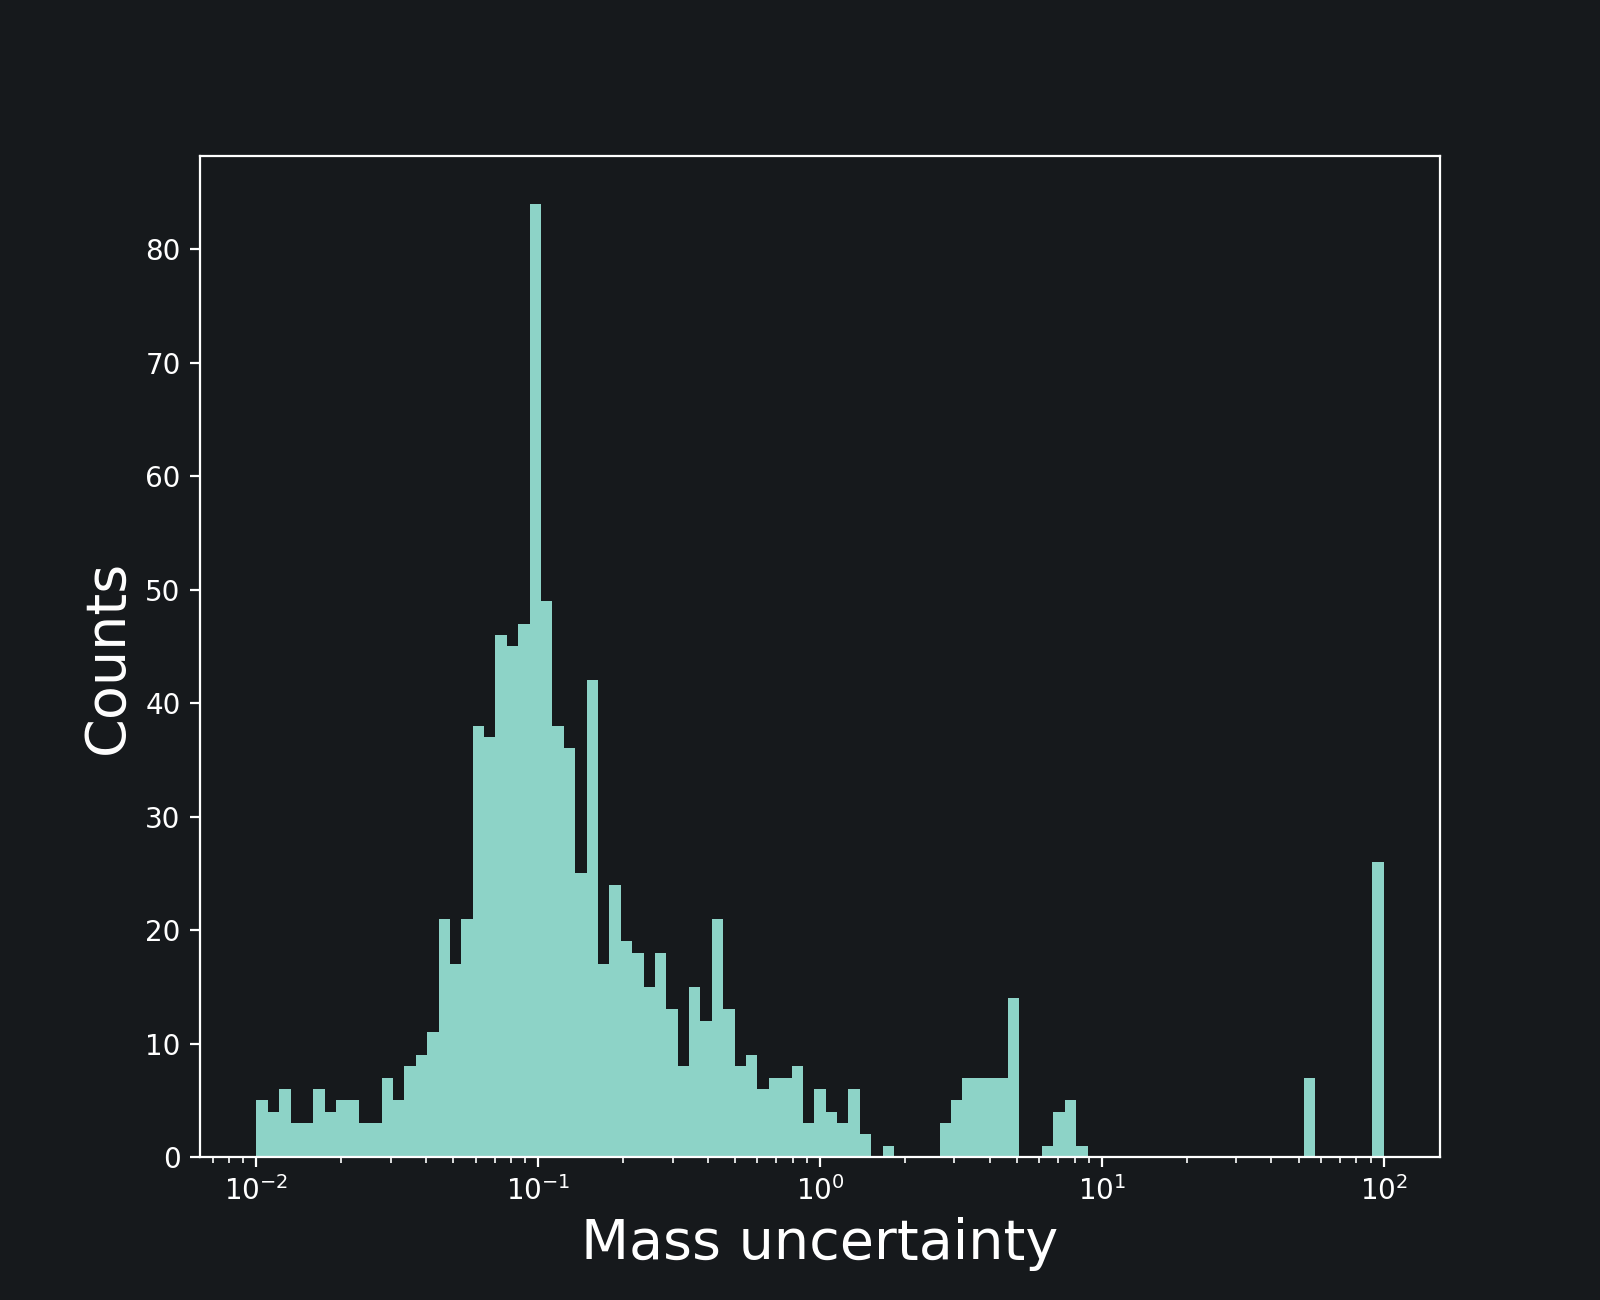

Text(0, 0.5, 'Counts')

In [14]:
f,ax=plt.subplots(figsize=(8,6.5))
ax.hist(pantheon.logm_err,bins=np.logspace(-2,2,100))
ax.set_xscale('log')
ax.set_xlabel('Mass uncertainty',size=20)
ax.set_ylabel('Counts',size=20)


Ok; it looks like errors are lognormally distributed with a cut at about 2. Let's assume that anything with an error larger than that is uncontrained, i.e. the data point is a limit!

<IPython.core.display.Javascript object>


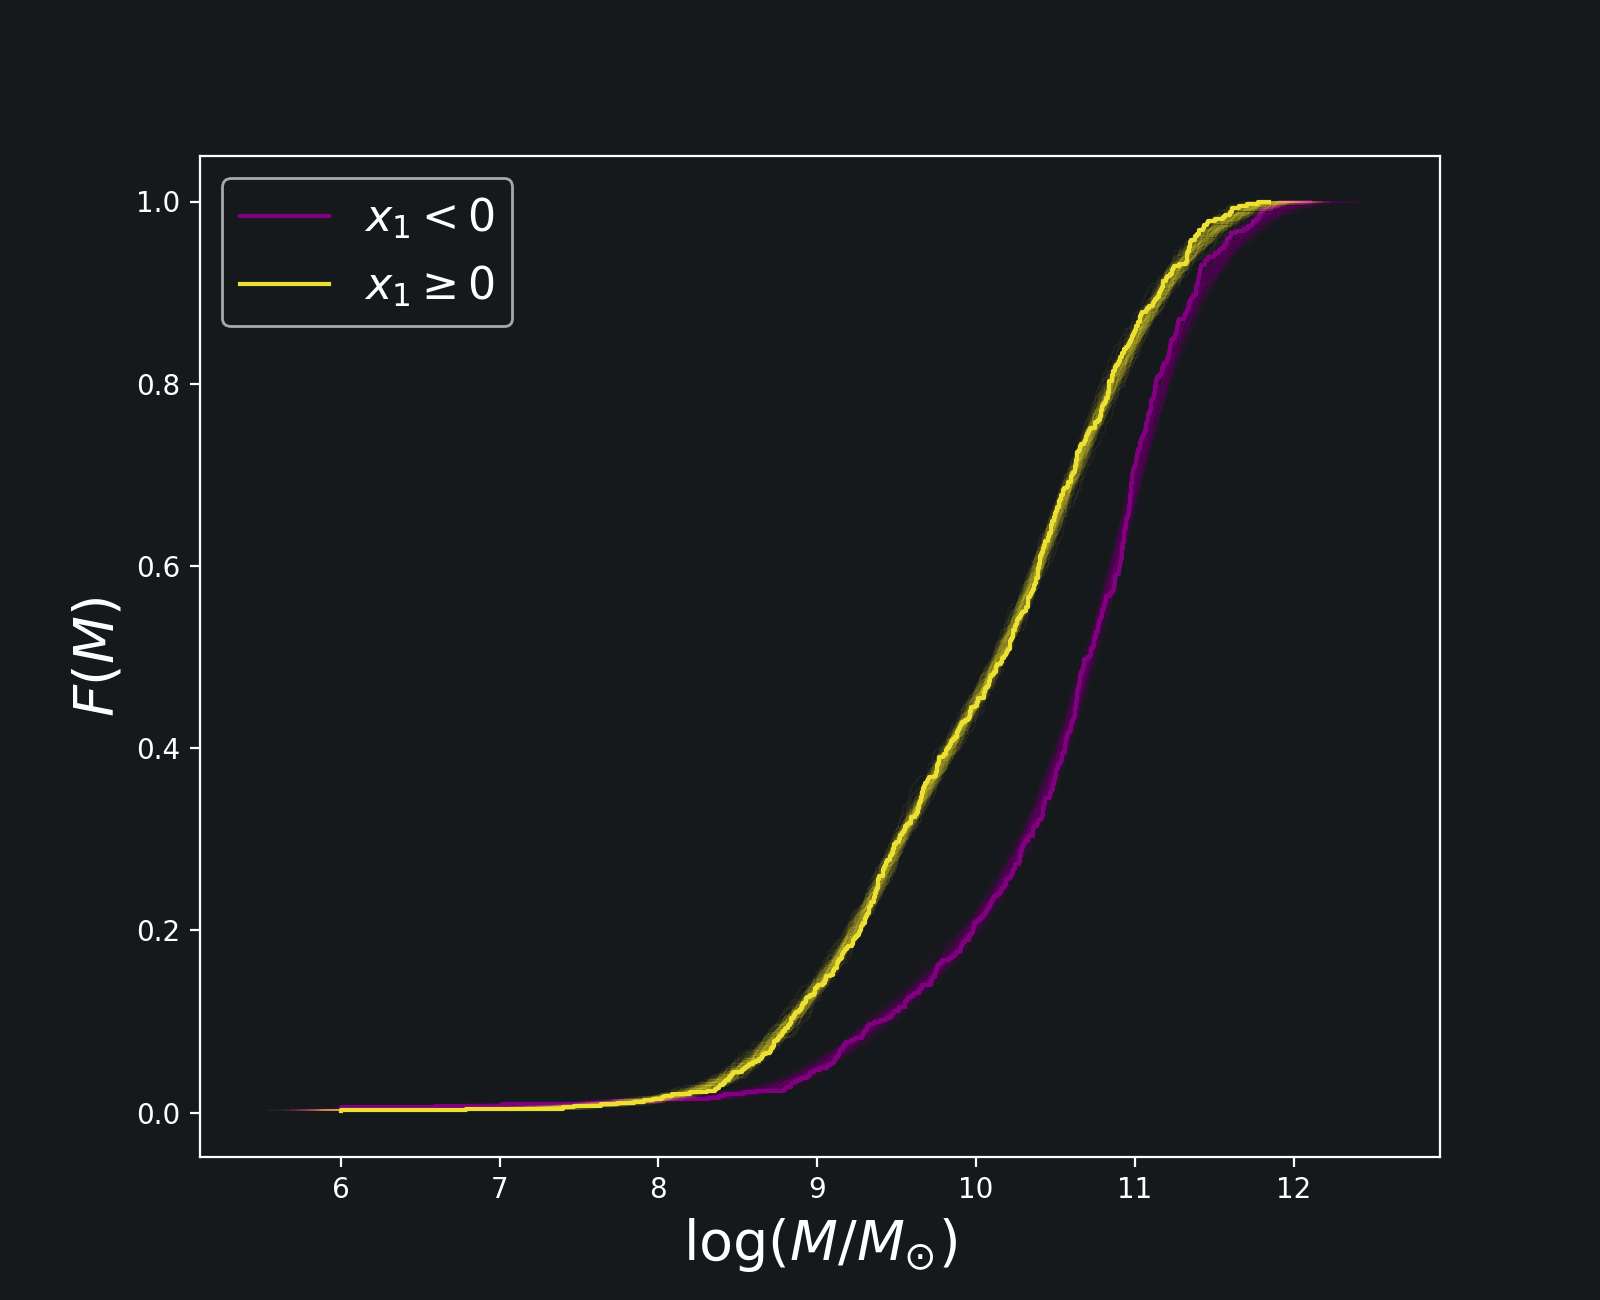

In [15]:
colours = itertools.cycle(['purple','y'])
f,ax=plt.subplots(figsize=(8,6.5))
for SNe,sample_name in zip([low_stretch_SNe,high_stretch_SNe],['$x_1 <0$','$x_1\geq0$']):
    SNe = SNe[SNe['logm_err']<2]
    sorted_ms,cdf = make_cdf(SNe['logm'])
    c = next(colours)
    ax.step(sorted_ms,cdf,label=sample_name,color=c)
    for i in range(100):
        perturbed = perturb_arr_normal(SNe['logm'],SNe['logm_err'],SNe['logm_err'])
        sorted_ms,cdf = make_cdf(perturbed)
        ax.step(sorted_ms,cdf,linewidth=0.025,color=c)
ax.set_xlabel('$\log (M/M_{\odot})$',size=20)
ax.set_ylabel('$F(M)$',size=20)
ax.legend(loc='upper left',fontsize=16)


Ok, so we now have 100 resampled CDFs that seem to bound the data for almost the entire range of the data. We're getting there! Let's go and do that horrible KS-testing stuff.

In [16]:
ks_stats = []
for i in range(1000):
    samples =[]
    for SNe,sample_name in zip([low_stretch_SNe,high_stretch_SNe],['$x_1 <0$','$x_1\geq0$']):
        SNe = SNe[SNe['logm_err']<2]
        perturbed = perturb_arr_normal(SNe['logm'],SNe['logm_err'],SNe['logm_err'])
        samples.append(perturbed)
    stat,pval = stats.ks_2samp(samples[0],samples[1])
    ks_stats.append([stat,pval])
ks_stats = np.array(ks_stats)    

In [17]:
print('KS mean: ',np.mean(ks_stats,axis=0))
print('KS std: ',np.std(ks_stats,axis=0))

KS mean:  [2.87639960e-01 1.87694305e-15]
KS std:  [1.09066507e-02 1.39015960e-14]


<IPython.core.display.Javascript object>


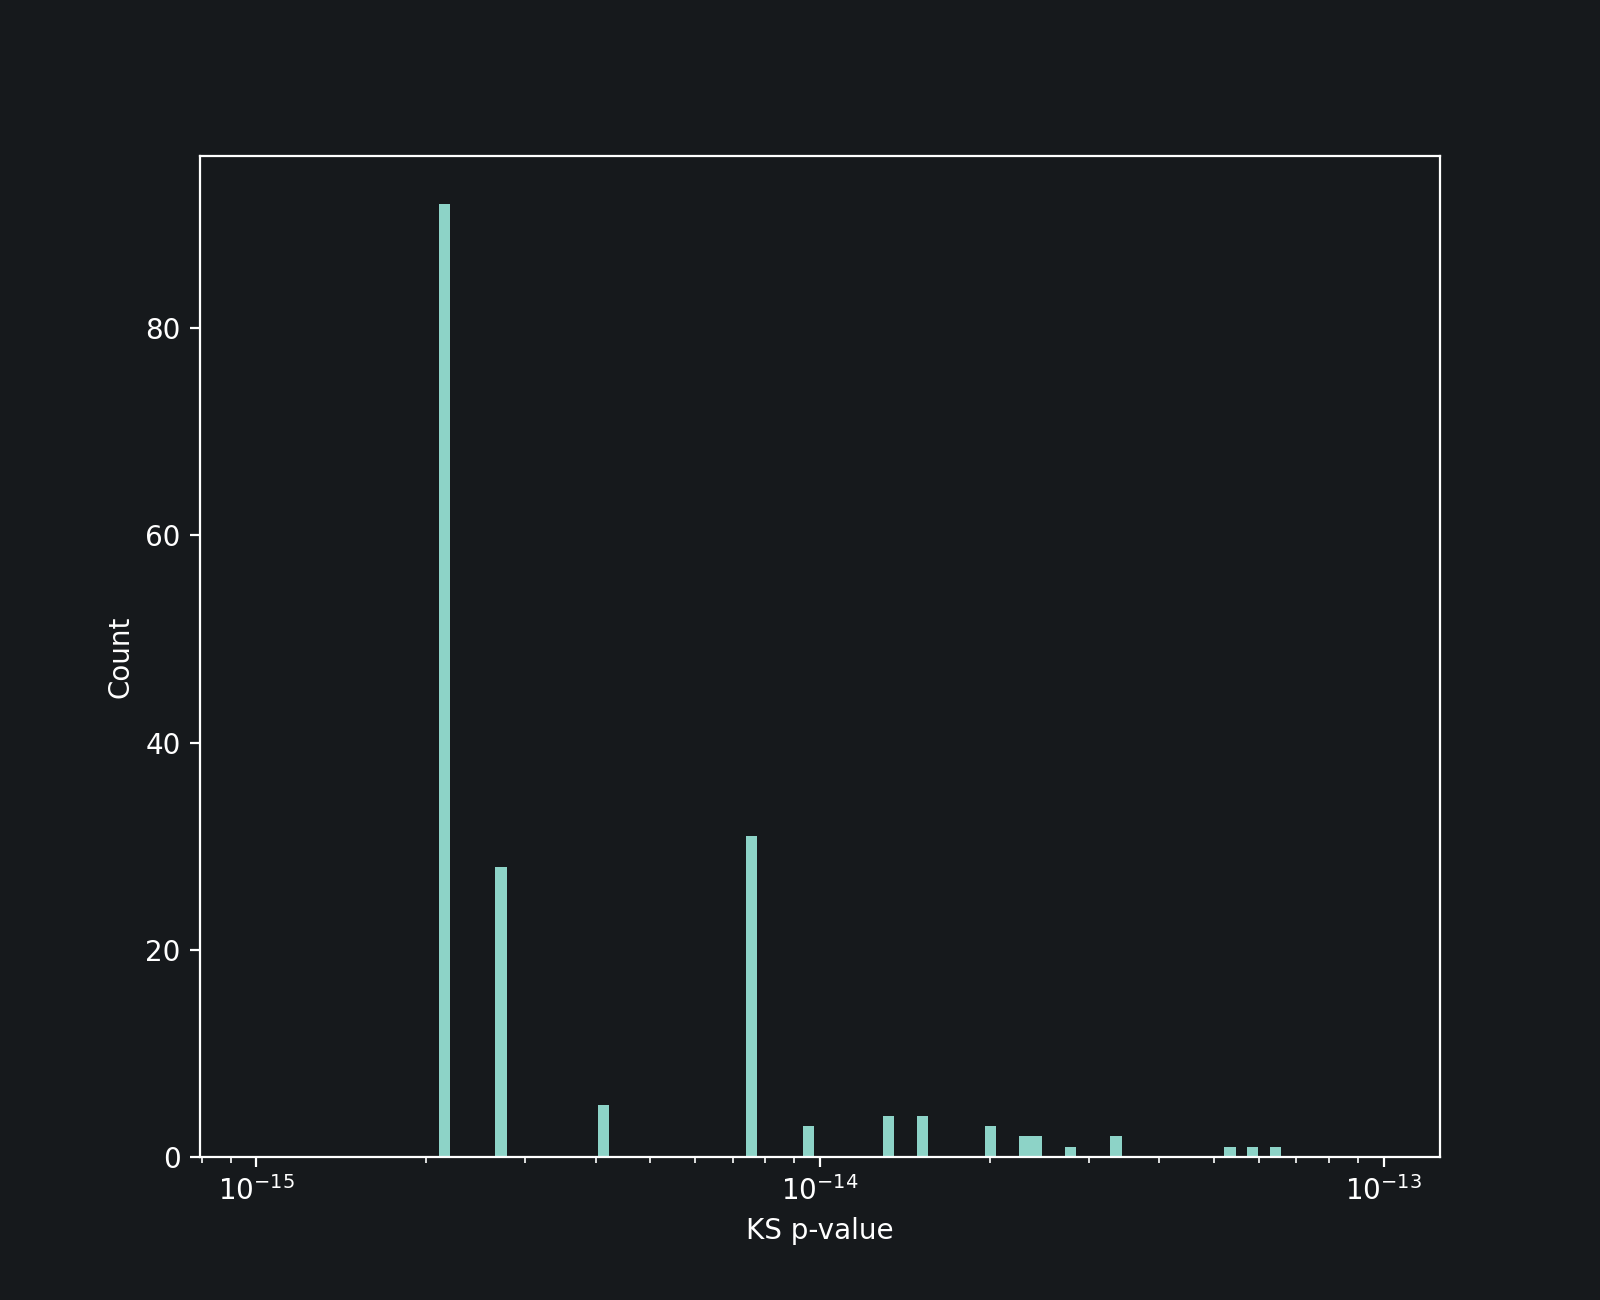

Text(0, 0.5, 'Count')

In [18]:
f,ax=plt.subplots(figsize=(8,6.5))
ax.hist(ks_stats[:,1],bins=np.logspace(-15,-13,100))
ax.set_xscale('log')
ax.set_xlabel('KS p-value')
ax.set_ylabel('Count')

Ok, not a good example as those samples are clearly different. How about SN colour?

<IPython.core.display.Javascript object>


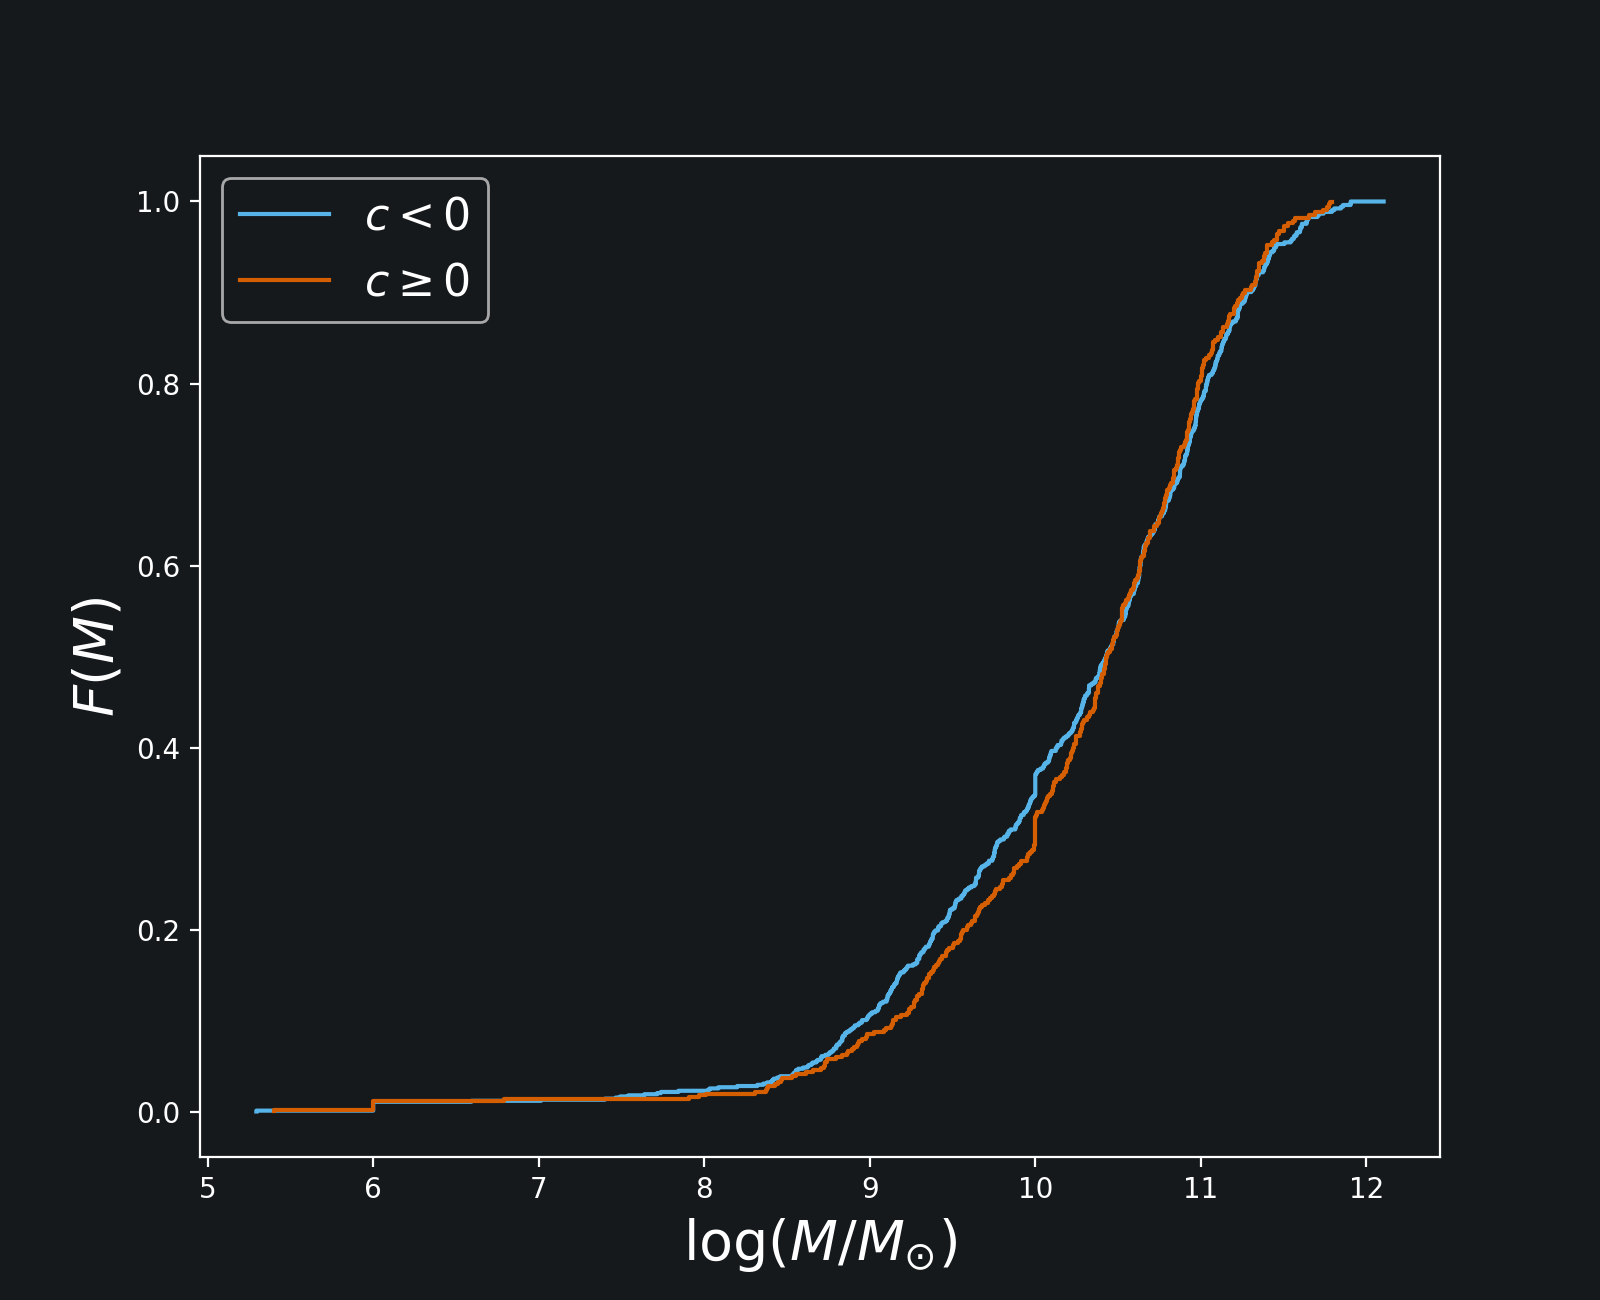

Text(0, 0.5, '$F(M)$')

In [19]:
stretch_cond = pantheon['c']<0
blue_SNe = pantheon[stretch_cond]
red_SNe = pantheon[~stretch_cond]
colours = itertools.cycle(['c','r'])
f,ax=plt.subplots(figsize=(8,6.5))
for SNe,sample_name in zip([blue_SNe,red_SNe],['$c <0$','$c\geq0$']):
    #SNe = SNe[SNe['logm_err']<2]
    sorted_ms,cdf = make_cdf(SNe['logm'])
    c = next(colours)
    
    ax.step(sorted_ms,cdf,label=sample_name,color=c)
ax.legend(fontsize=16)
ax.set_xlabel('$\log (M/M_{\odot})$',size=20)
ax.set_ylabel('$F(M)$',size=20)


<IPython.core.display.Javascript object>


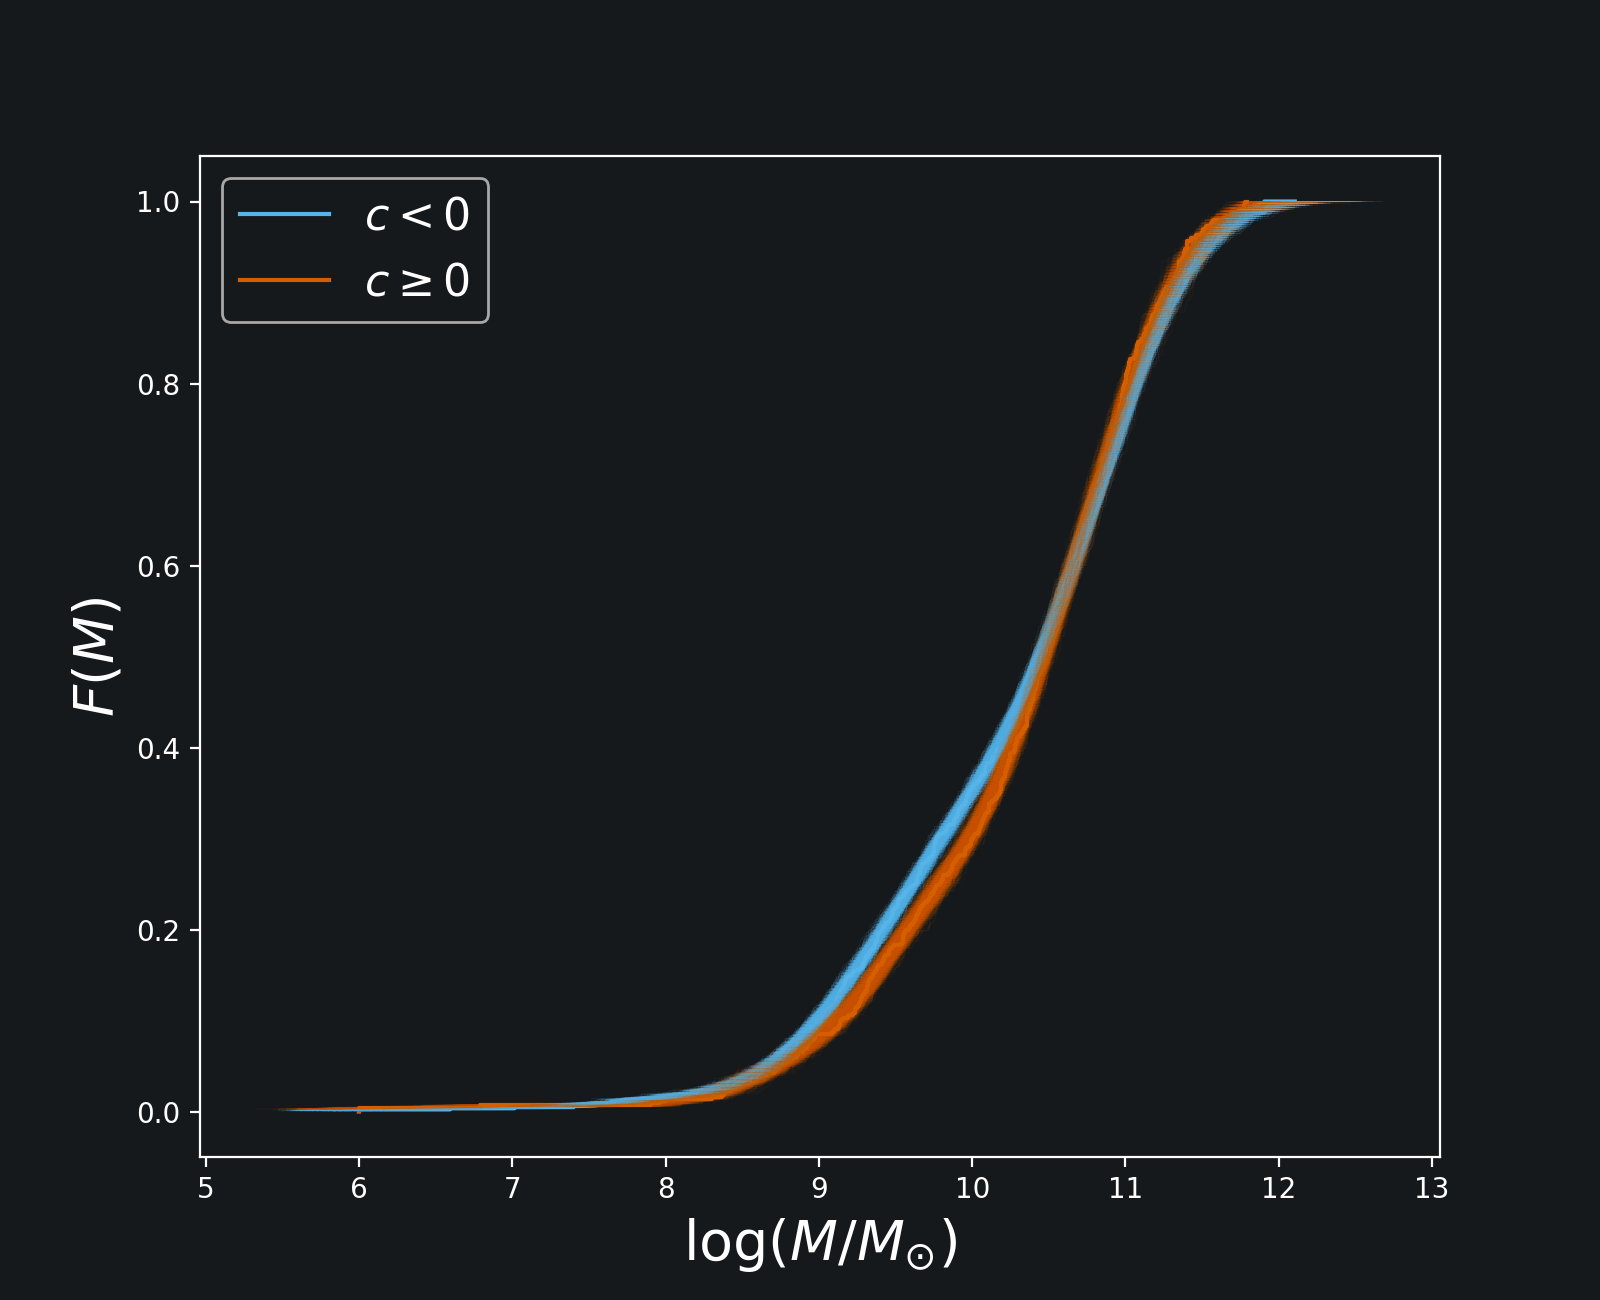

KS stat:  0.06612608438232039 KS pval:  0.29053979263886043
KS mean:  [0.06950438 0.25823059]
KS std:  [0.00808116 0.11499058]


In [20]:
f,ax=plt.subplots(figsize=(8,6.5))

samples = []
for SNe,sample_name in zip([blue_SNe,red_SNe],['$c <0$','$c\geq0$']):
    SNe = SNe[SNe['logm_err']<2]
    sorted_ms,cdf = make_cdf(SNe['logm'])
    c = next(colours)
    samples.append(SNe.logm)
    ax.step(sorted_ms,cdf,label=sample_name,color=c)

stat,pval = stats.ks_2samp(samples[0],samples[1])
print('KS stat: ',stat,'KS pval: ',pval)
ks_stats = []
for i in range(1000):
    samples = []
    for SNe in [blue_SNe,red_SNe]:
        c = next(colours)
        SNe = SNe[SNe['logm_err']<2]
        perturbed = perturb_arr_normal(SNe['logm'],SNe['logm_err'],SNe['logm_err'])
        sorted_ms,cdf = make_cdf(perturbed)
        ax.step(sorted_ms,cdf,linewidth=0.025,color=c)
        samples.append(perturbed)
    stat,pval = stats.ks_2samp(samples[0],samples[1])
    ks_stats.append([stat,pval])
ks_stats = np.array(ks_stats)   
ax.set_xlabel('$\log (M/M_{\odot})$',size=20)
ax.set_ylabel('$F(M)$',size=20)
ax.legend(loc='upper left',fontsize=16)
print('KS mean: ',np.mean(ks_stats,axis=0))
print('KS std: ',np.std(ks_stats,axis=0))

We can see that the mean KS values are slightly different from the fiducial one, although well within the uncertainty. But look at the variance of that p-value - it's huge. In this case, the samples are fairly close, but what if we choose a different colour to split our sample at

<IPython.core.display.Javascript object>


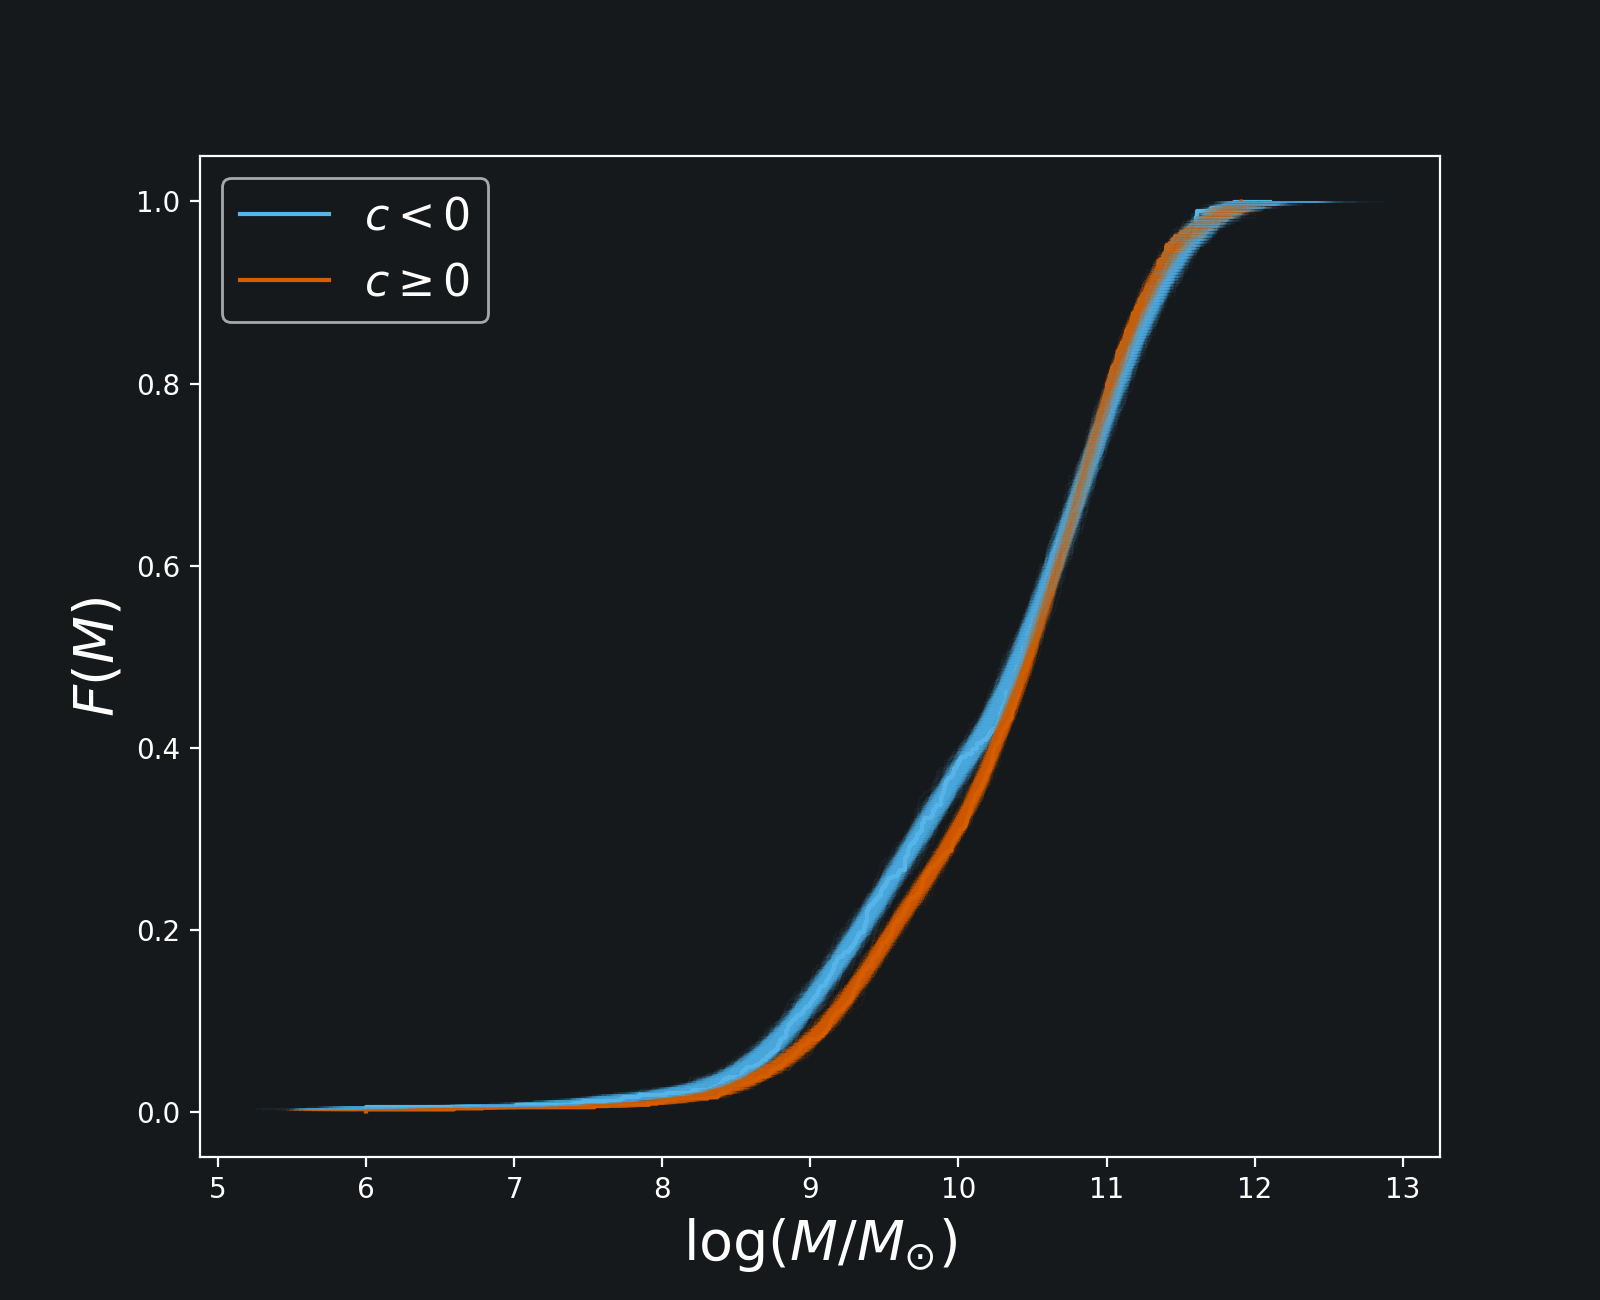

KS stat:  0.08837029773206201 KS pval:  0.06855218953212117
KS mean:  [0.08555474 0.09719233]
KS std:  [0.00819553 0.05615003]


In [21]:
stretch_cond = pantheon['c']<-0.05
blue_SNe = pantheon[stretch_cond]
red_SNe = pantheon[~stretch_cond]
colours = itertools.cycle(['c','r'])

f,ax=plt.subplots(figsize=(8,6.5))

samples = []
for SNe,sample_name in zip([blue_SNe,red_SNe],['$c <0$','$c\geq0$']):
    SNe = SNe[SNe['logm_err']<2]
    sorted_ms,cdf = make_cdf(SNe['logm'])
    c = next(colours)
    samples.append(SNe.logm)
    ax.step(sorted_ms,cdf,label=sample_name,color=c)
stat,pval = stats.ks_2samp(samples[0],samples[1])
print('KS stat: ',stat,'KS pval: ',pval)
ks_stats = []
for i in range(1000):
    samples = []
    for SNe in [blue_SNe,red_SNe]:
        c = next(colours)
        SNe = SNe[SNe['logm_err']<2]
        perturbed = perturb_arr_normal(SNe['logm'],SNe['logm_err'],SNe['logm_err'])
        sorted_ms,cdf = make_cdf(perturbed)
        ax.step(sorted_ms,cdf,linewidth=0.025,color=c)
        samples.append(perturbed)
    stat,pval = stats.ks_2samp(samples[0],samples[1])
    ks_stats.append([stat,pval])
ks_stats = np.array(ks_stats)   
ax.set_xlabel('$\log (M/M_{\odot})$',size=20)
ax.set_ylabel('$F(M)$',size=20)
ax.legend(loc='upper left',fontsize=16)

print('KS mean: ',np.mean(ks_stats,axis=0))
print('KS std: ',np.std(ks_stats,axis=0))

<IPython.core.display.Javascript object>


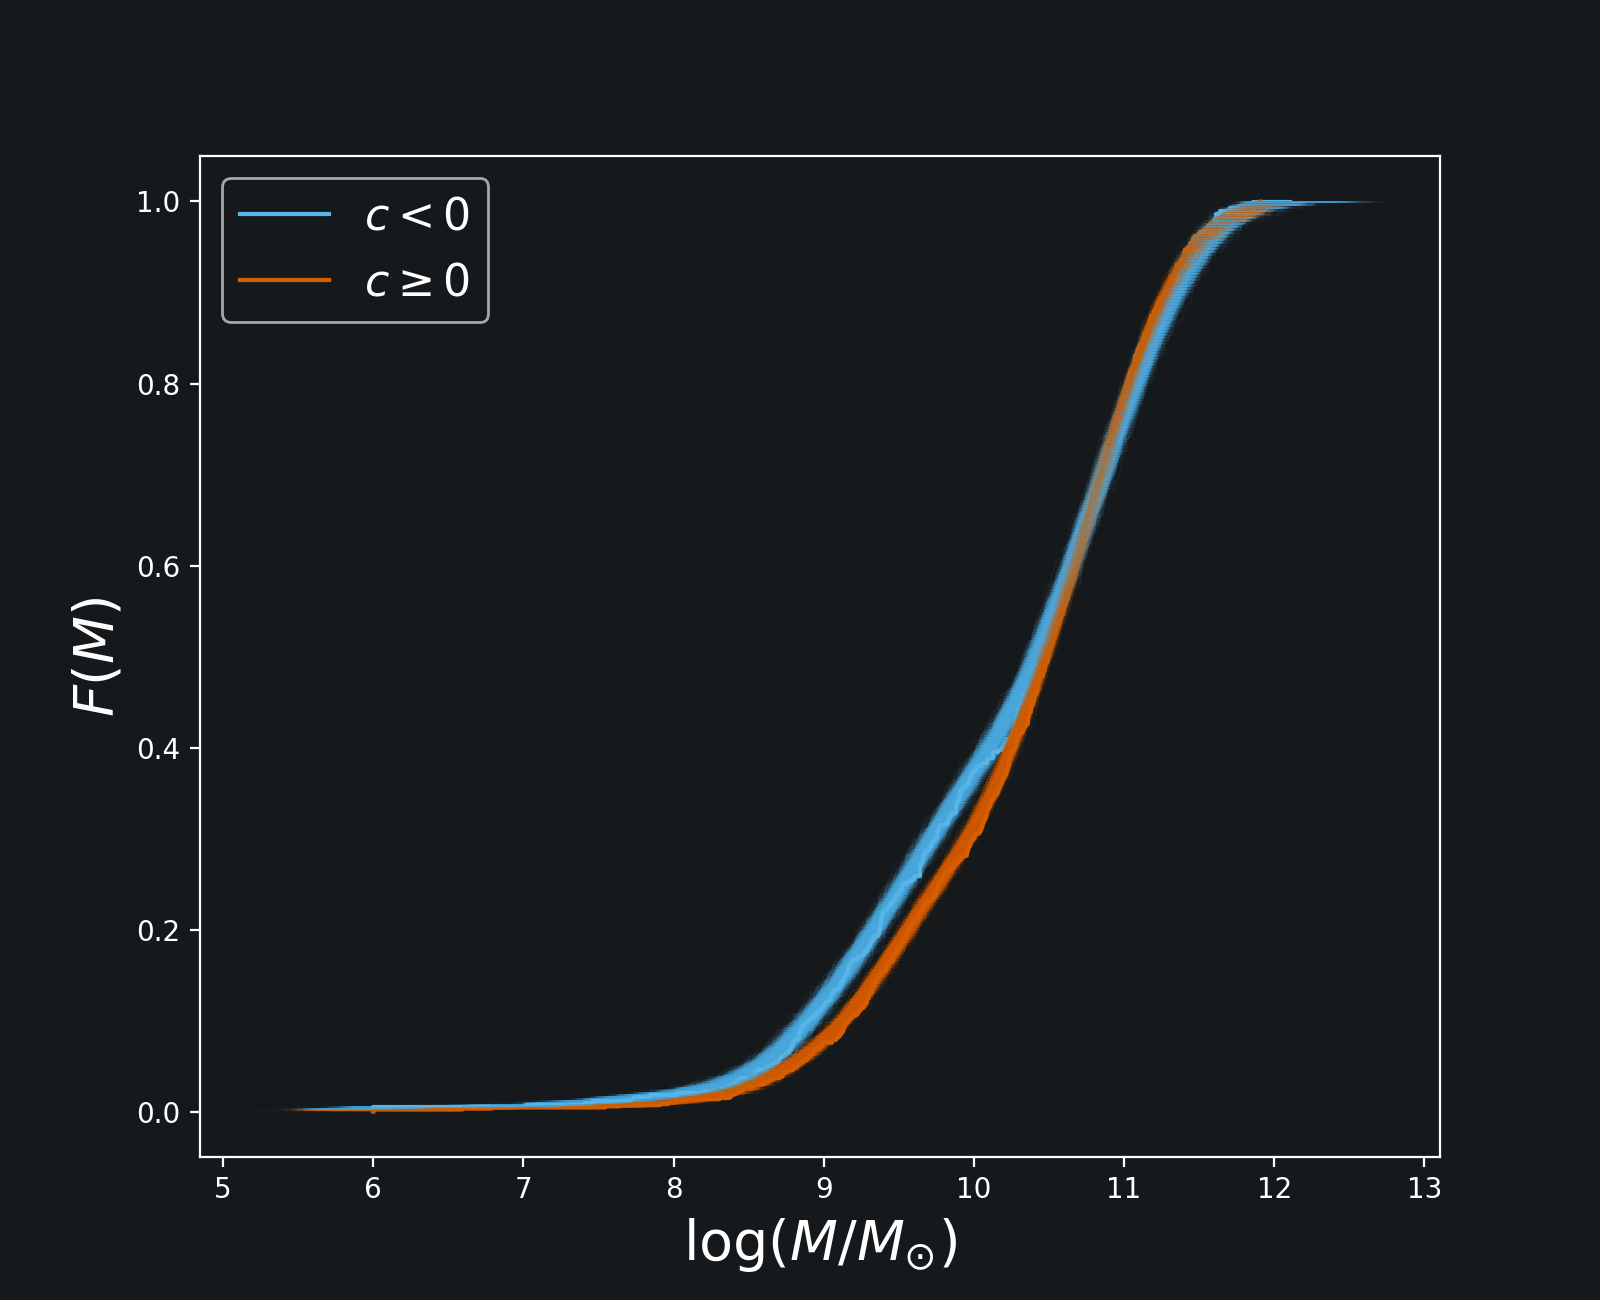

KS stat:  0.08474691142868208 KS pval:  0.08080865507690549
KS mean:  [0.08581936 0.09397366]
KS std:  [0.0077621  0.04995435]


In [22]:
stretch_cond = pantheon['c']<-0.05
blue_SNe = pantheon[stretch_cond]
red_SNe = pantheon[~stretch_cond]
colours = itertools.cycle(['c','r'])

f,ax=plt.subplots(figsize=(8,6.5))

samples = []
for SNe,sample_name in zip([blue_SNe,red_SNe],['$c <0$','$c\geq0$']):
    SNe = SNe[SNe['logm_err']<5]
    sorted_ms,cdf = make_cdf(SNe['logm'])
    c = next(colours)
    samples.append(SNe.logm)
    ax.step(sorted_ms,cdf,label=sample_name,color=c)
stat,pval = stats.ks_2samp(samples[0],samples[1])
print('KS stat: ',stat,'KS pval: ',pval)
ks_stats = []
for i in range(1000):
    samples = []
    for SNe in [blue_SNe,red_SNe]:
        c = next(colours)
        SNe = SNe[SNe['logm_err']<2]
        perturbed = perturb_arr_normal(SNe['logm'],SNe['logm_err'],SNe['logm_err'])
        sorted_ms,cdf = make_cdf(perturbed)
        ax.step(sorted_ms,cdf,linewidth=0.025,color=c)
        samples.append(perturbed)
    stat,pval = stats.ks_2samp(samples[0],samples[1])
    ks_stats.append([stat,pval])
ks_stats = np.array(ks_stats)   
ax.set_xlabel('$\log (M/M_{\odot})$',size=20)
ax.set_ylabel('$F(M)$',size=20)
ax.legend(loc='upper left',fontsize=16)

print('KS mean: ',np.mean(ks_stats,axis=0))
print('KS std: ',np.std(ks_stats,axis=0))

Our fiducial value is dangerously close to the "magical" 0.05, but our resamples produce a more confusing picture -- the mean is larger, but the spread suggests that there's a non-zero chance that the p-value is actually <0.05! 

## Whatever, cool But I came here for upper limits!

Let's have a look at where our limits lie in the mass plane

<IPython.core.display.Javascript object>


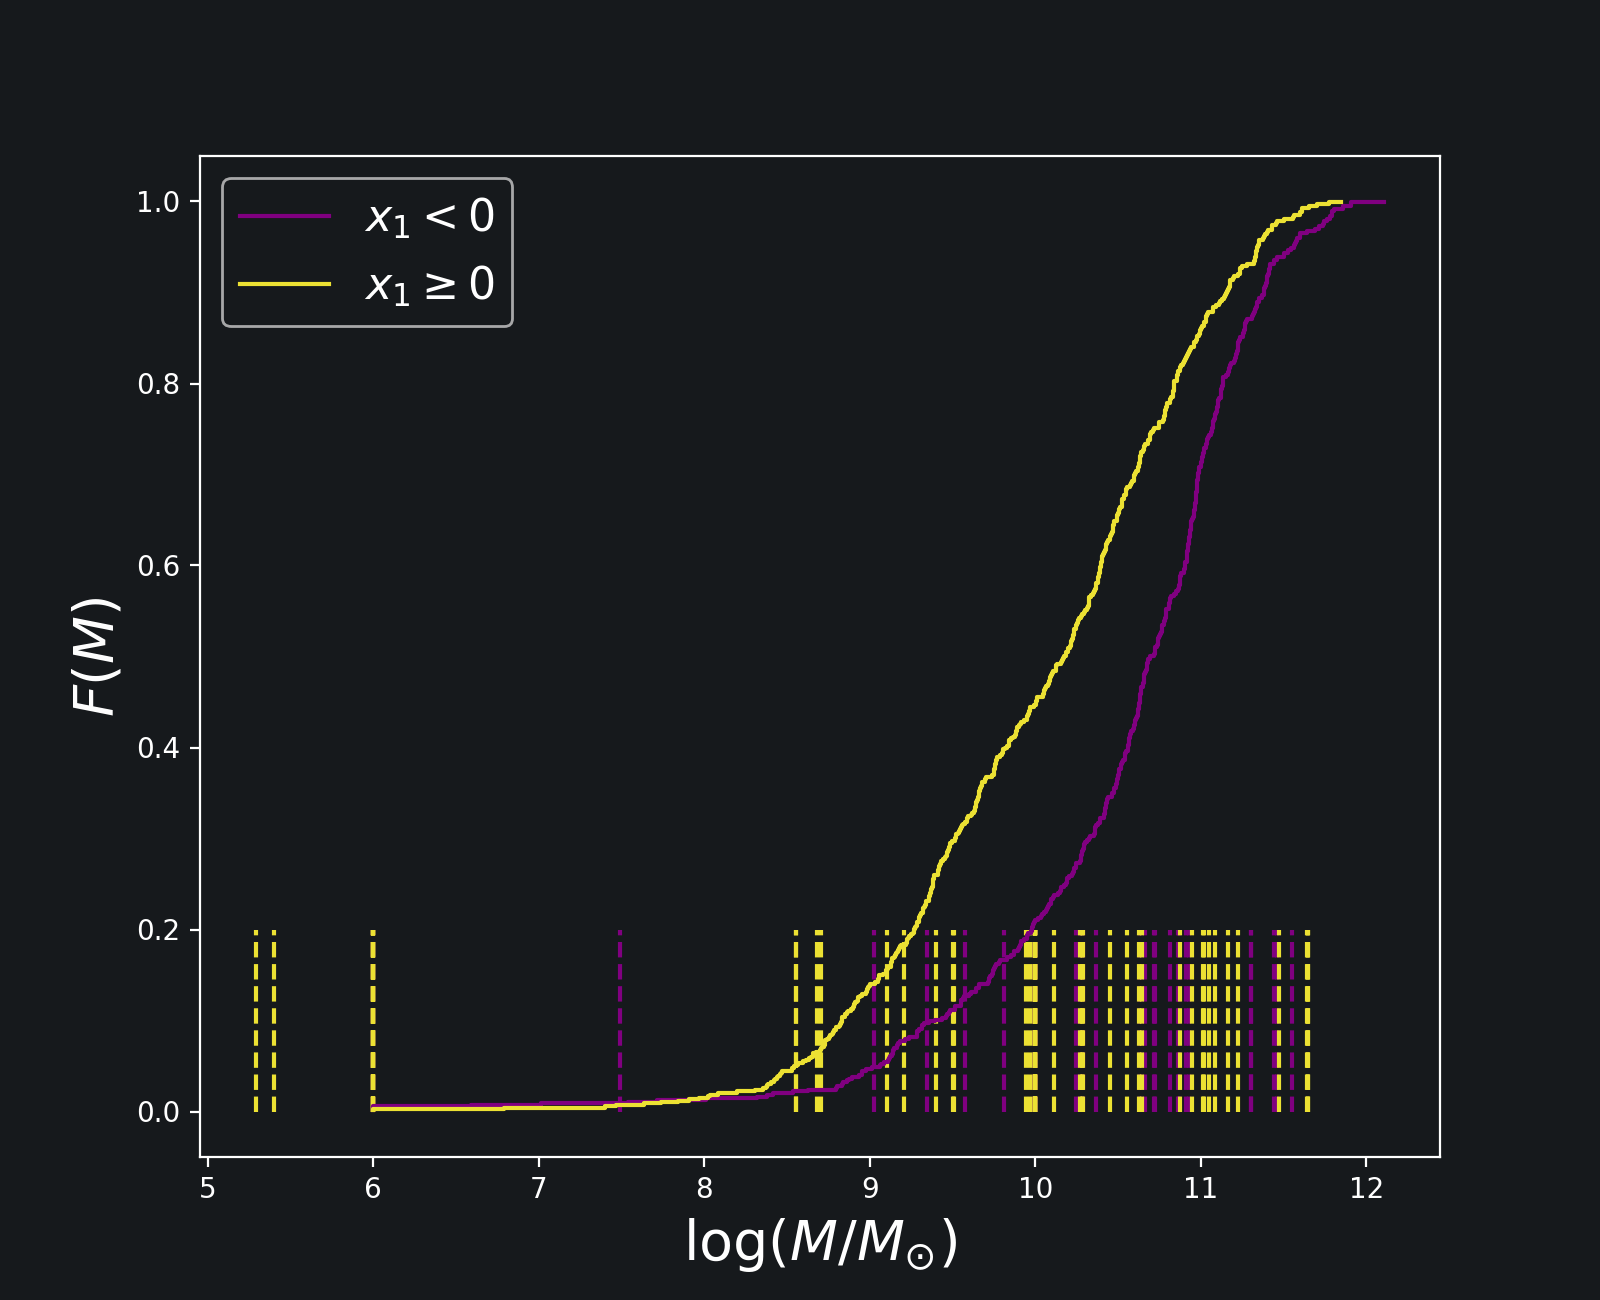

<IPython.core.display.Javascript object>


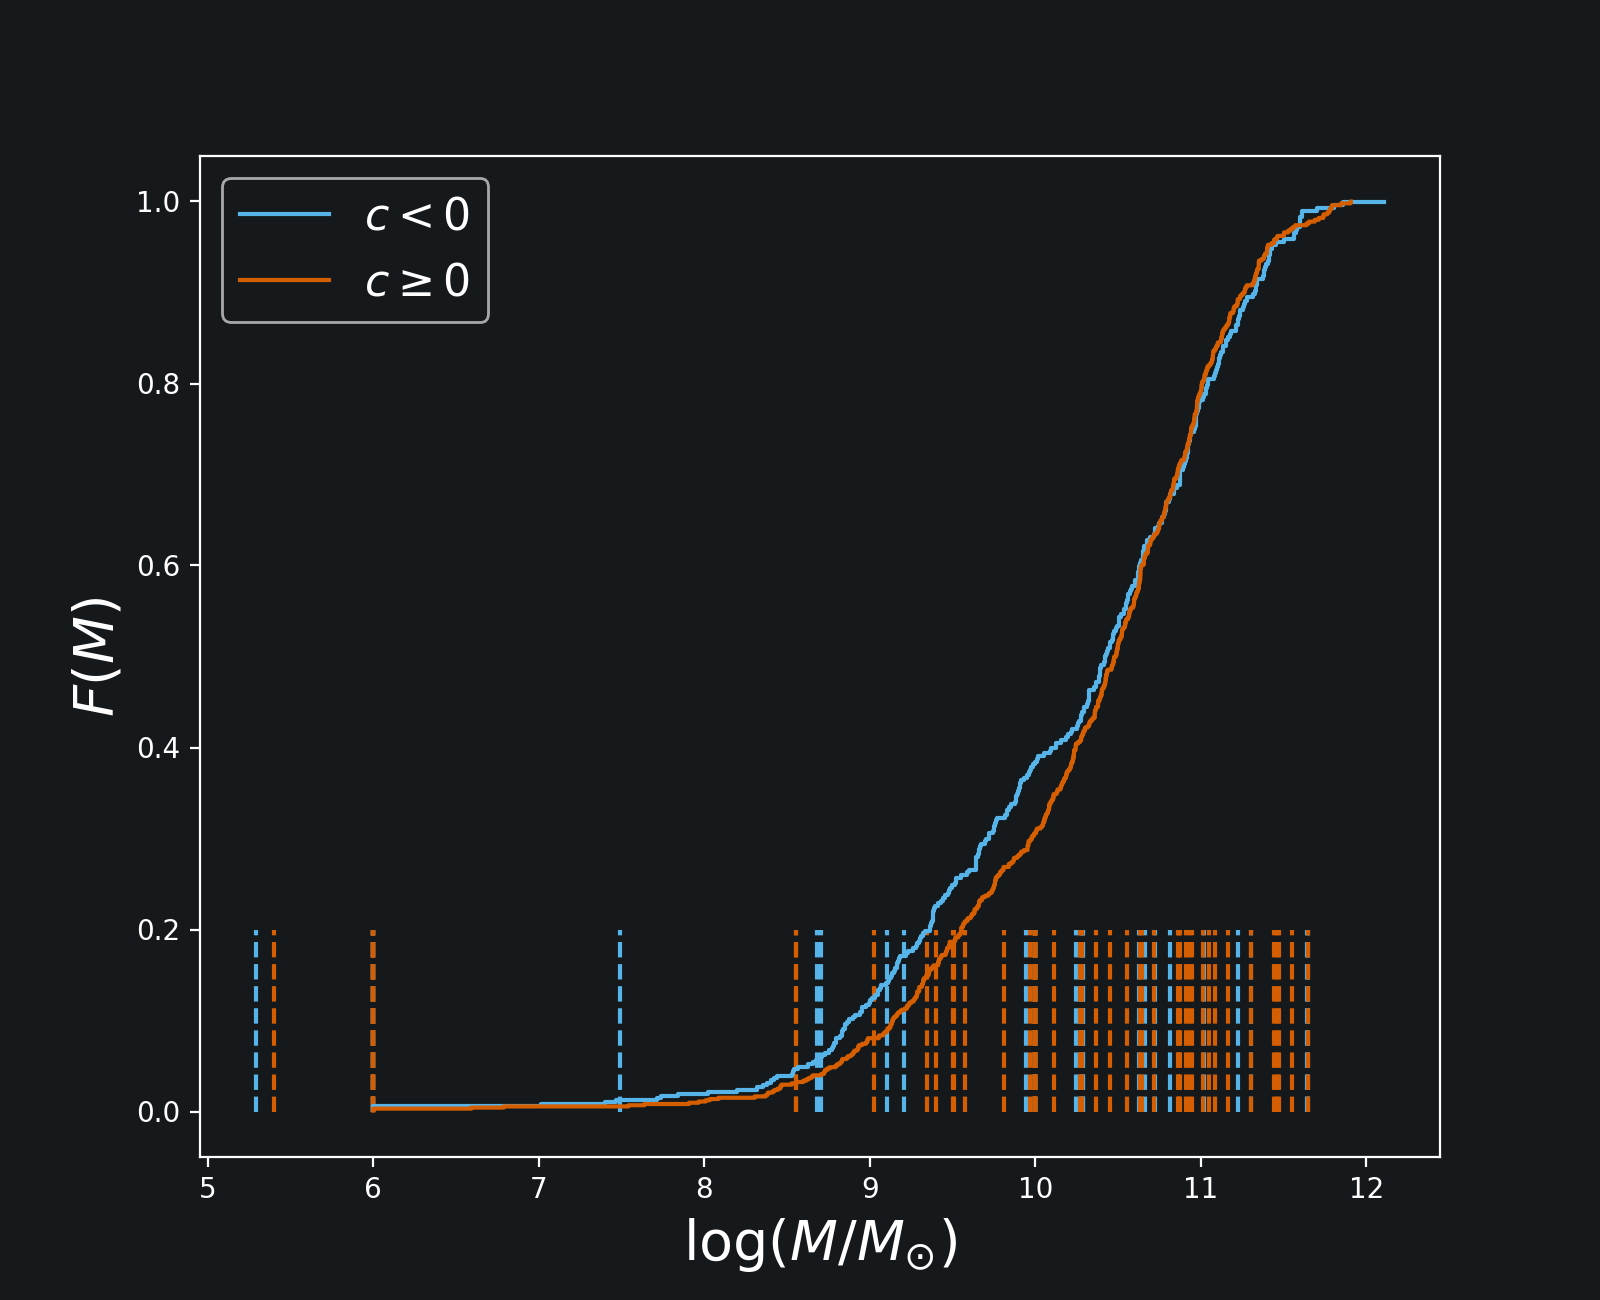

Text(0, 0.5, '$F(M)$')

In [23]:
f,ax=plt.subplots(figsize=(8,6.5))
colours = itertools.cycle(['purple','y'])
for SNe,sample_name in zip([low_stretch_SNe,high_stretch_SNe],['$x_1 <0$','$x_1\geq0$']):
    limits = SNe[SNe['logm_err']>=2]
    SNe = SNe[SNe['logm_err']<2]
    sorted_ms,cdf = make_cdf(SNe['logm'])
    c = next(colours)
    ax.step(sorted_ms,cdf,color=c,label=sample_name)
    for l in limits.logm.values:
        ax.vlines(l,0,0.2,color=c,linestyle='--')
ax.legend(fontsize=16)
ax.set_xlabel('$\log (M/M_{\odot})$',size=20)
ax.set_ylabel('$F(M)$',size=20)

colours = itertools.cycle(['c','r'])
f,ax=plt.subplots(figsize=(8,6.5))
for SNe,sample_name in zip([blue_SNe,red_SNe],['$c <0$','$c\geq0$']):
    limits = SNe[SNe['logm_err']>=2]
    SNe = SNe[SNe['logm_err']<2]
    sorted_ms,cdf = make_cdf(SNe['logm'])
    c = next(colours)
    ax.step(sorted_ms,cdf,color=c,label=sample_name)
    for l in limits.logm.values:
        ax.vlines(l,0,0.2,color=c,linestyle='--')
ax.legend(fontsize=16)
ax.set_xlabel('$\log (M/M_{\odot})$',size=20)
ax.set_ylabel('$F(M)$',size=20)


Hmm, that's not showing us much. What happens if we see how the CDF changes compared to the one with no limits, if we assume that the limits are detections?

<IPython.core.display.Javascript object>


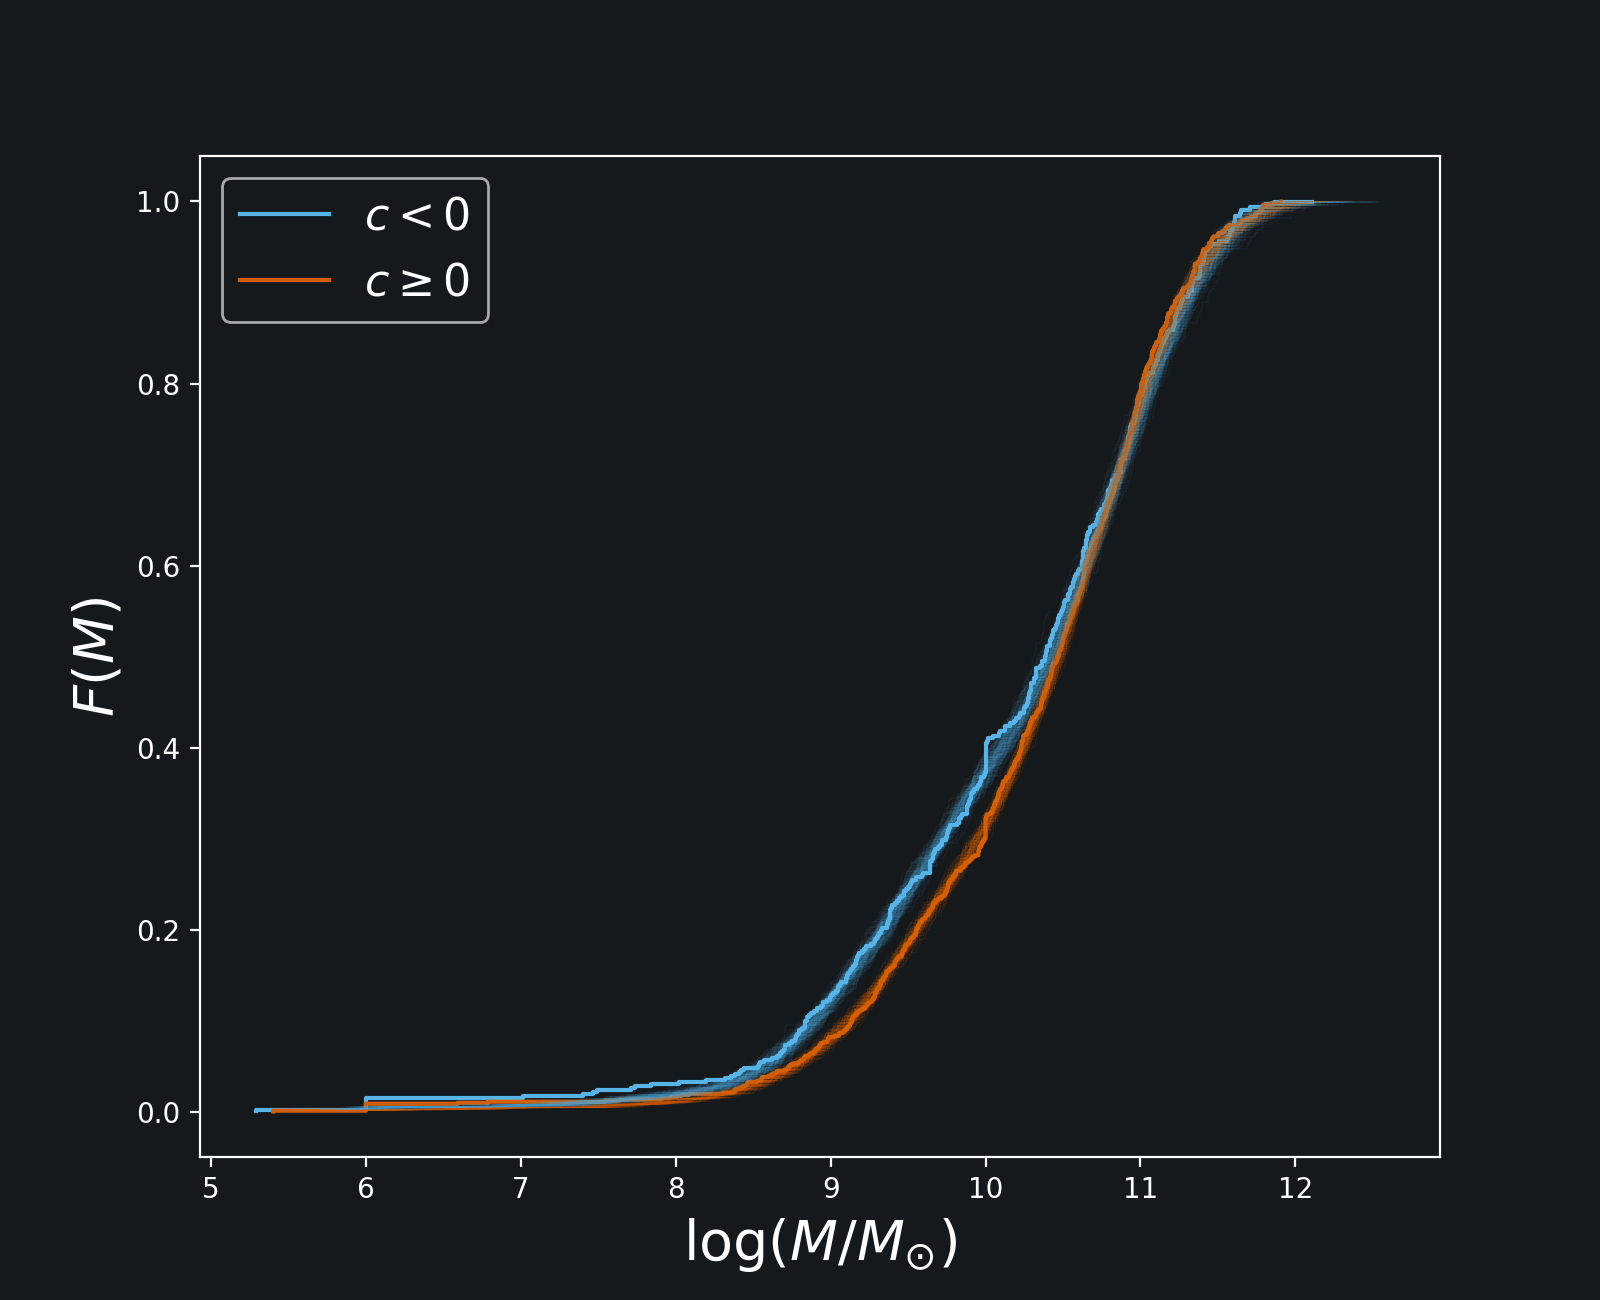

In [24]:
f,ax=plt.subplots(figsize=(8,6.5))

colours = itertools.cycle(['c','r'])
for SNe,sample_name in zip([blue_SNe,red_SNe],['$c <0$','$c\geq0$']):
    #SNe = SNe[SNe['logm_err']<2]
    sorted_ms,cdf = make_cdf(SNe['logm'])
    c = next(colours)
    ax.step(sorted_ms,cdf,label=sample_name,color=c)

for i in range(100):
    for SNe in [blue_SNe,red_SNe]:
        c = next(colours)
        SNe = SNe[SNe['logm_err']<2]
        perturbed = perturb_arr_normal(SNe['logm'],SNe['logm_err'],SNe['logm_err'])
        sorted_ms,cdf = make_cdf(perturbed)
        ax.step(sorted_ms,cdf,linewidth=0.025,color=c)
        
    
ax.set_xlabel('$\log (M/M_{\odot})$',size=20)
ax.set_ylabel('$F(M)$',size=20)
ax.legend(loc='upper left',fontsize=16)


Let's see if we can impute our limits using Stan. We'll assume the true values of our non-detections are drawn from the same distribution as the detections. Let's model them as random variables obeying the same likelihood. Our "prior" is flat, but we constrain them to be below or equal to the reported upper limit.
So, detections $m_i \sim \mathcal{N} (\mu, \sigma)$ and limits $l_i \sim \mathcal{N} (\mu, \sigma)$

In [25]:
detections = pantheon[(pantheon['logm_err']<2)].sort_values('logm')#&(pantheon['logm']>=6.5)]
limits = pantheon[(pantheon['logm_err']>=2)].sort_values('logm')# &(pantheon['logm']>6.5)].sort_values('logm')

In [26]:
import stan_utility

In [27]:


data = dict(
    N_obs = len(detections),
    N_cens = len(limits),
    y_obs = detections.logm.values,
    y_cens = limits.logm.values
    )

from des_sn_hosts.utils import stan_utility
model =stan_utility.compile_model('stan_models/normal_survival.stan')           

fit =model.sampling(data=data, seed=1234, iter=int(2000),warmup=1000,n_jobs=4)

chains=fit.extract()

f,ax=plt.subplots()
ax.scatter(limits.logm,np.median(chains['latent_y_cens_raw'],axis=0))
    
ax.set_xlabel('$\log (M/M_{\odot})$',size=20)
ax.set_ylabel('Mean Pull',size=20)
all_log_ms = np.concatenate([np.mean(chains['latent_y_cens'],axis=0).T,detections.logm.values.T])

Using cached StanModel


<IPython.core.display.Javascript object>

We can see that on average, limits that are not well constrained get pulled further than those that are very tight constraints. 

<IPython.core.display.Javascript object>


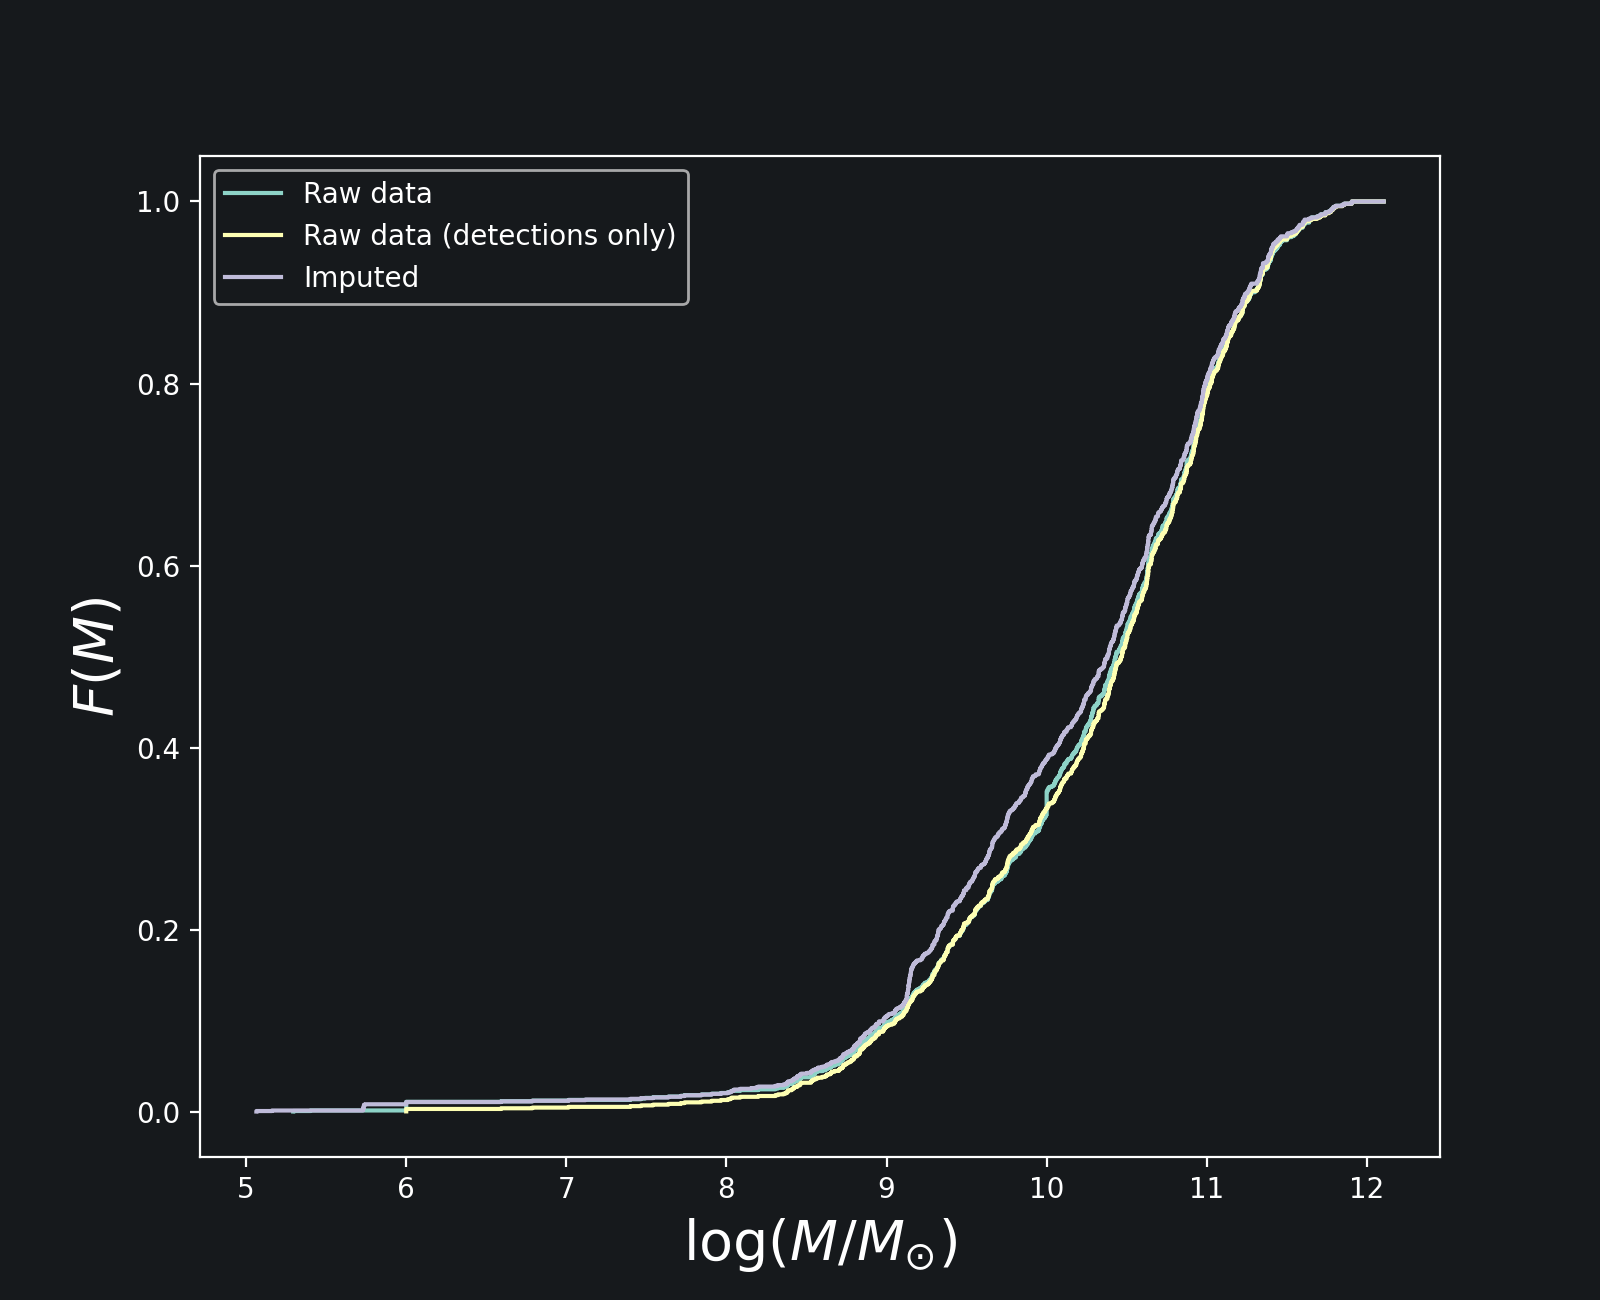

Text(0, 0.5, '$F(M)$')

In [28]:
f,ax=plt.subplots(figsize=(8,6.5))
for mass_array,name in zip([pantheon.logm,detections.logm,all_log_ms],['Raw data','Raw data (detections only)','Imputed']):
    sorted_ms,cdf = make_cdf(mass_array)
    ax.step(sorted_ms,cdf,label=name)
ax.legend()
    
ax.set_xlabel('$\log (M/M_{\odot})$',size=20)
ax.set_ylabel('$F(M)$',size=20)

<IPython.core.display.Javascript object>


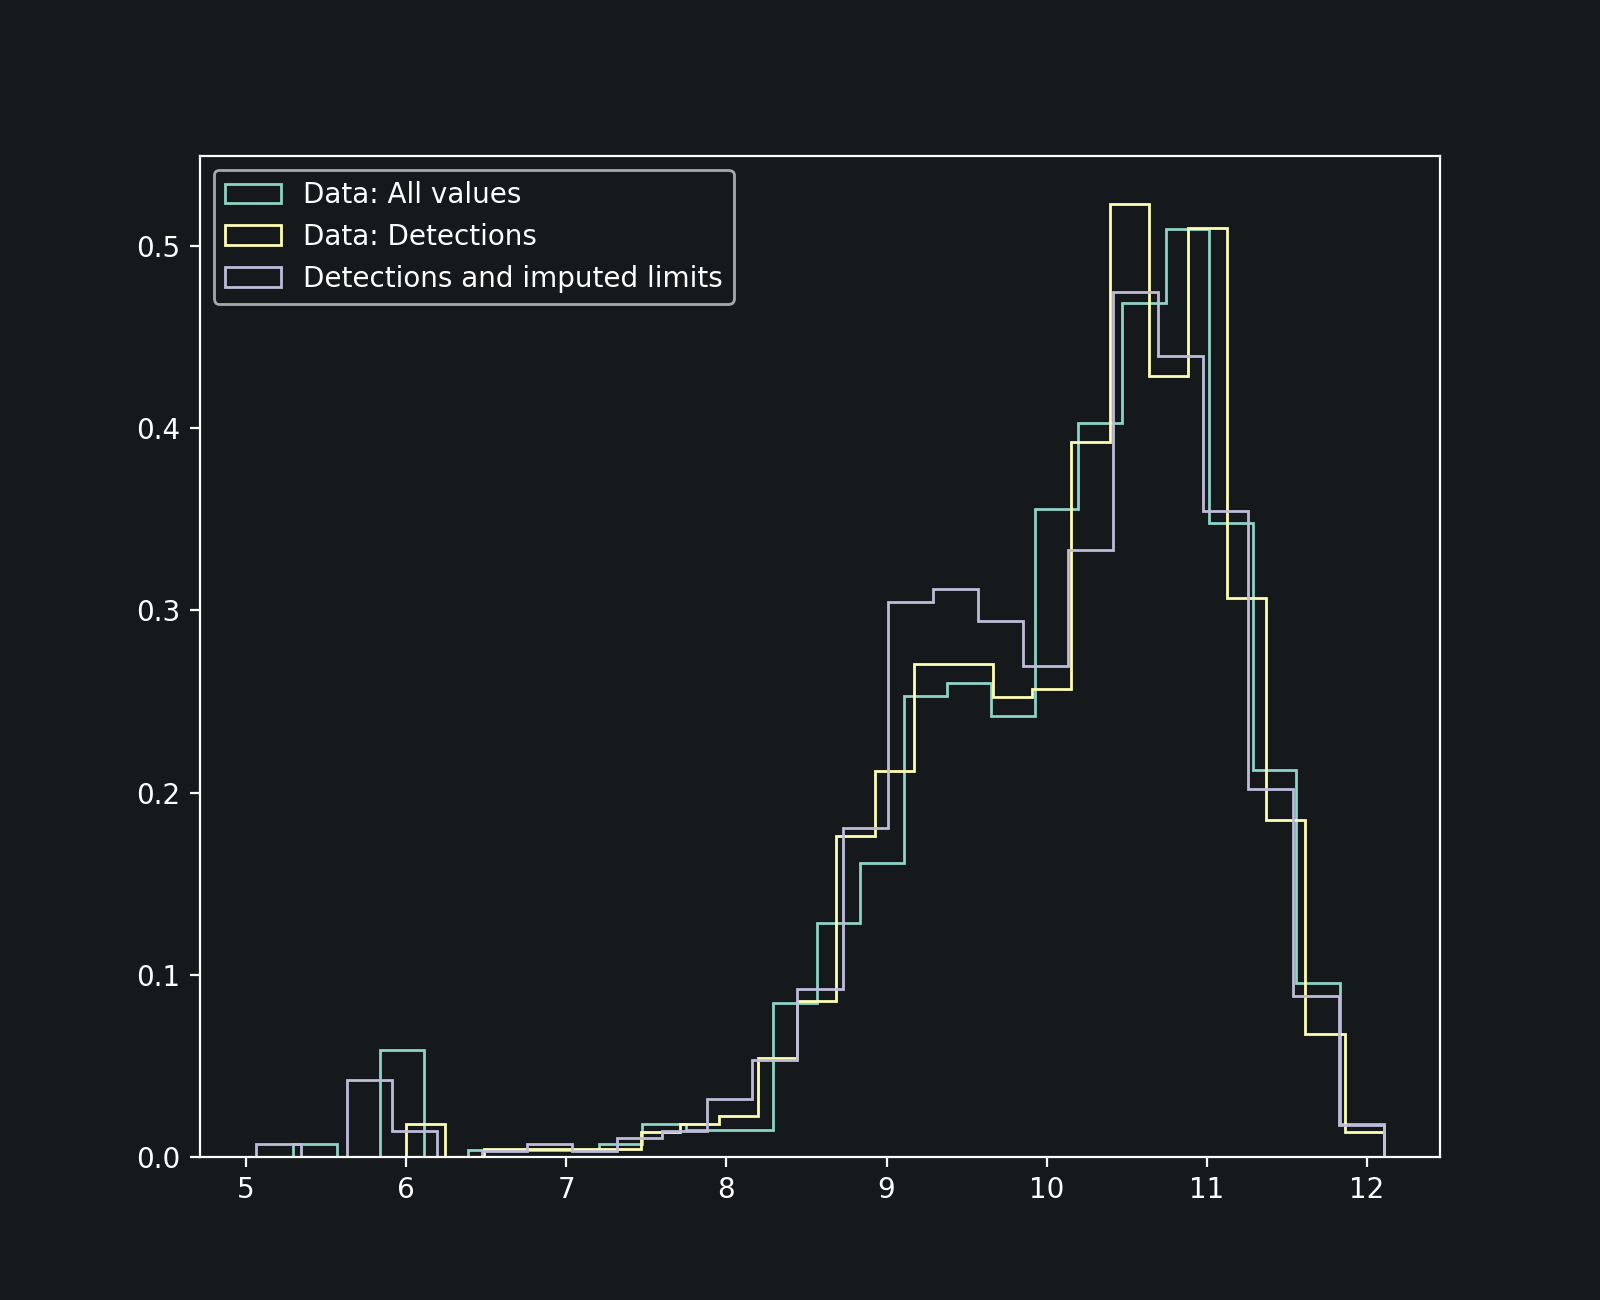

In [30]:
f,ax=plt.subplots(figsize=(8,6.5))
ax.hist(pantheon.logm,density=True,histtype='step',bins=25,label='Data: All values')
ax.hist(detections.logm,density=True,histtype='step',bins=25,label='Data: Detections')
ax.hist(all_log_ms,density=True,histtype='step',bins=25,label='Detections and imputed limits')
ax.legend(loc='upper left')


Using cached StanModel
Using cached StanModel


<IPython.core.display.Javascript object>


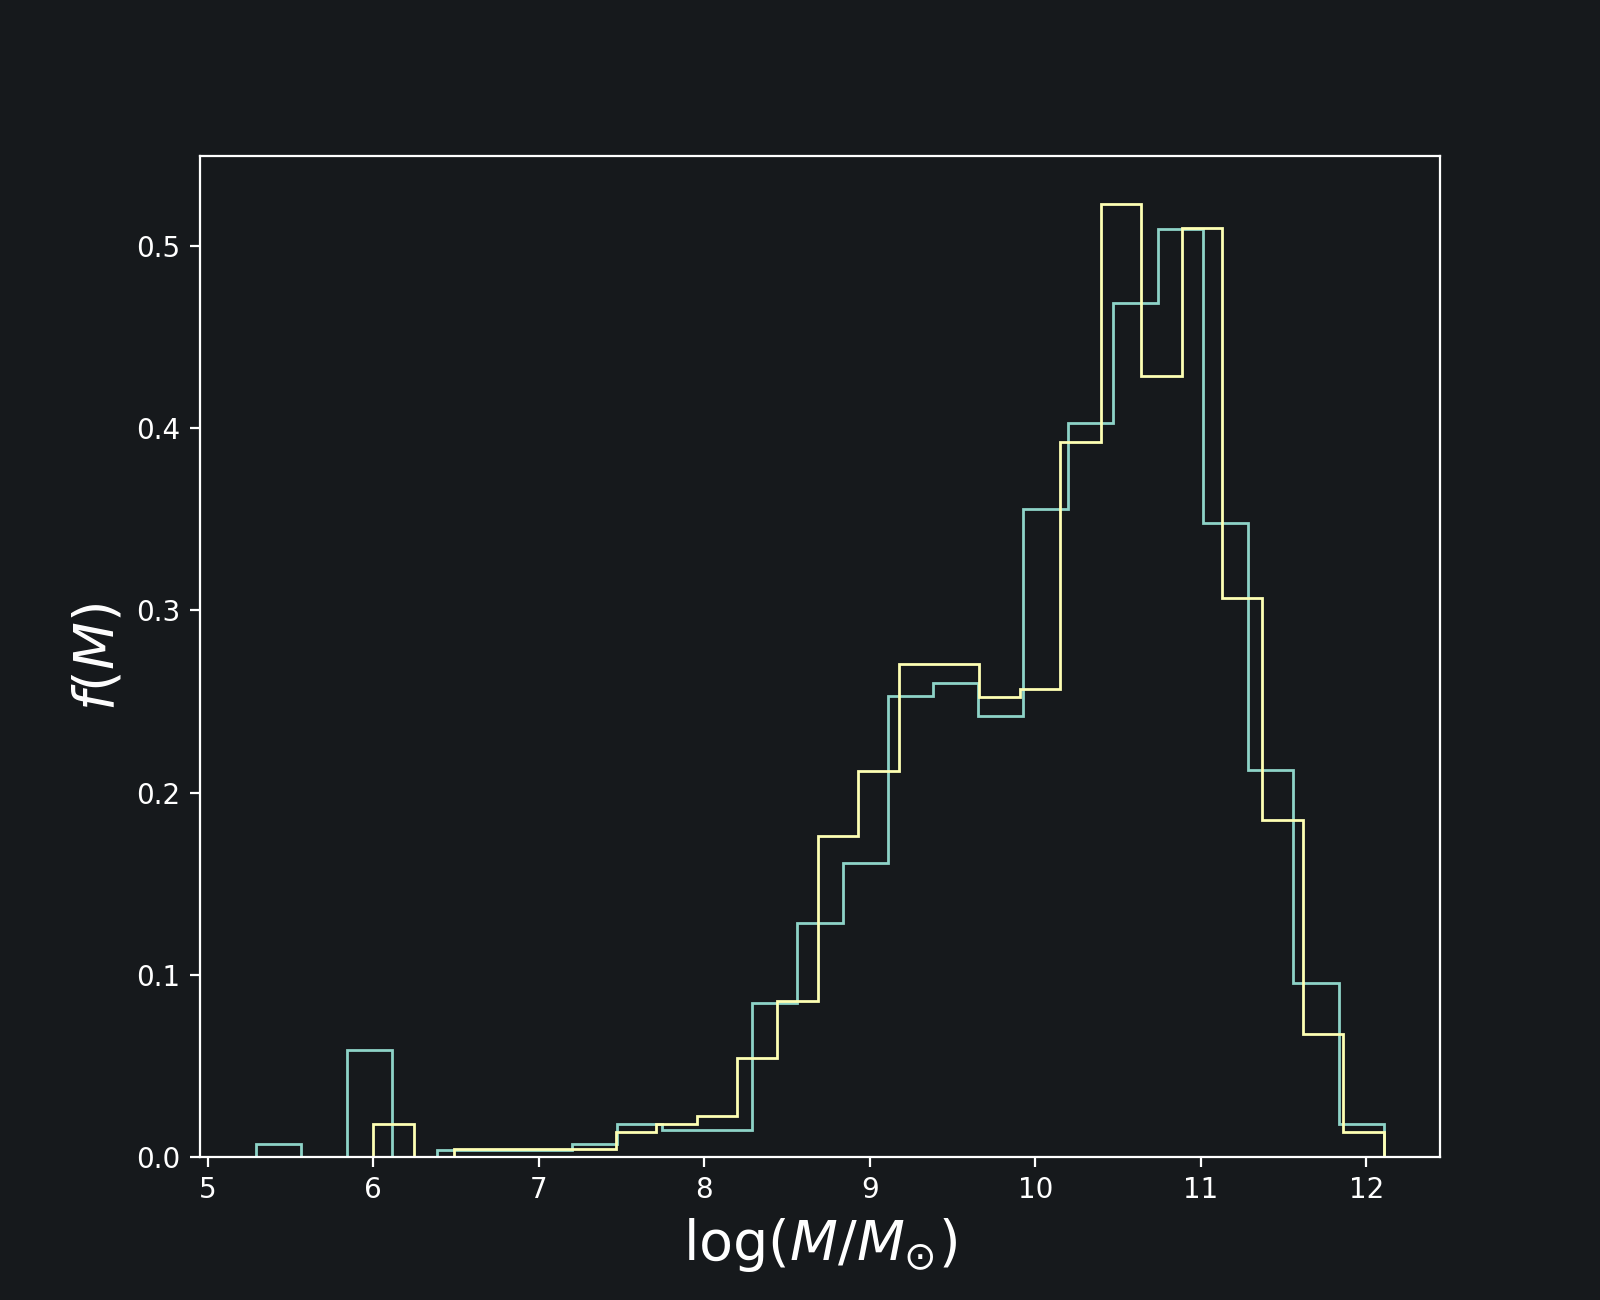

<IPython.core.display.Javascript object>


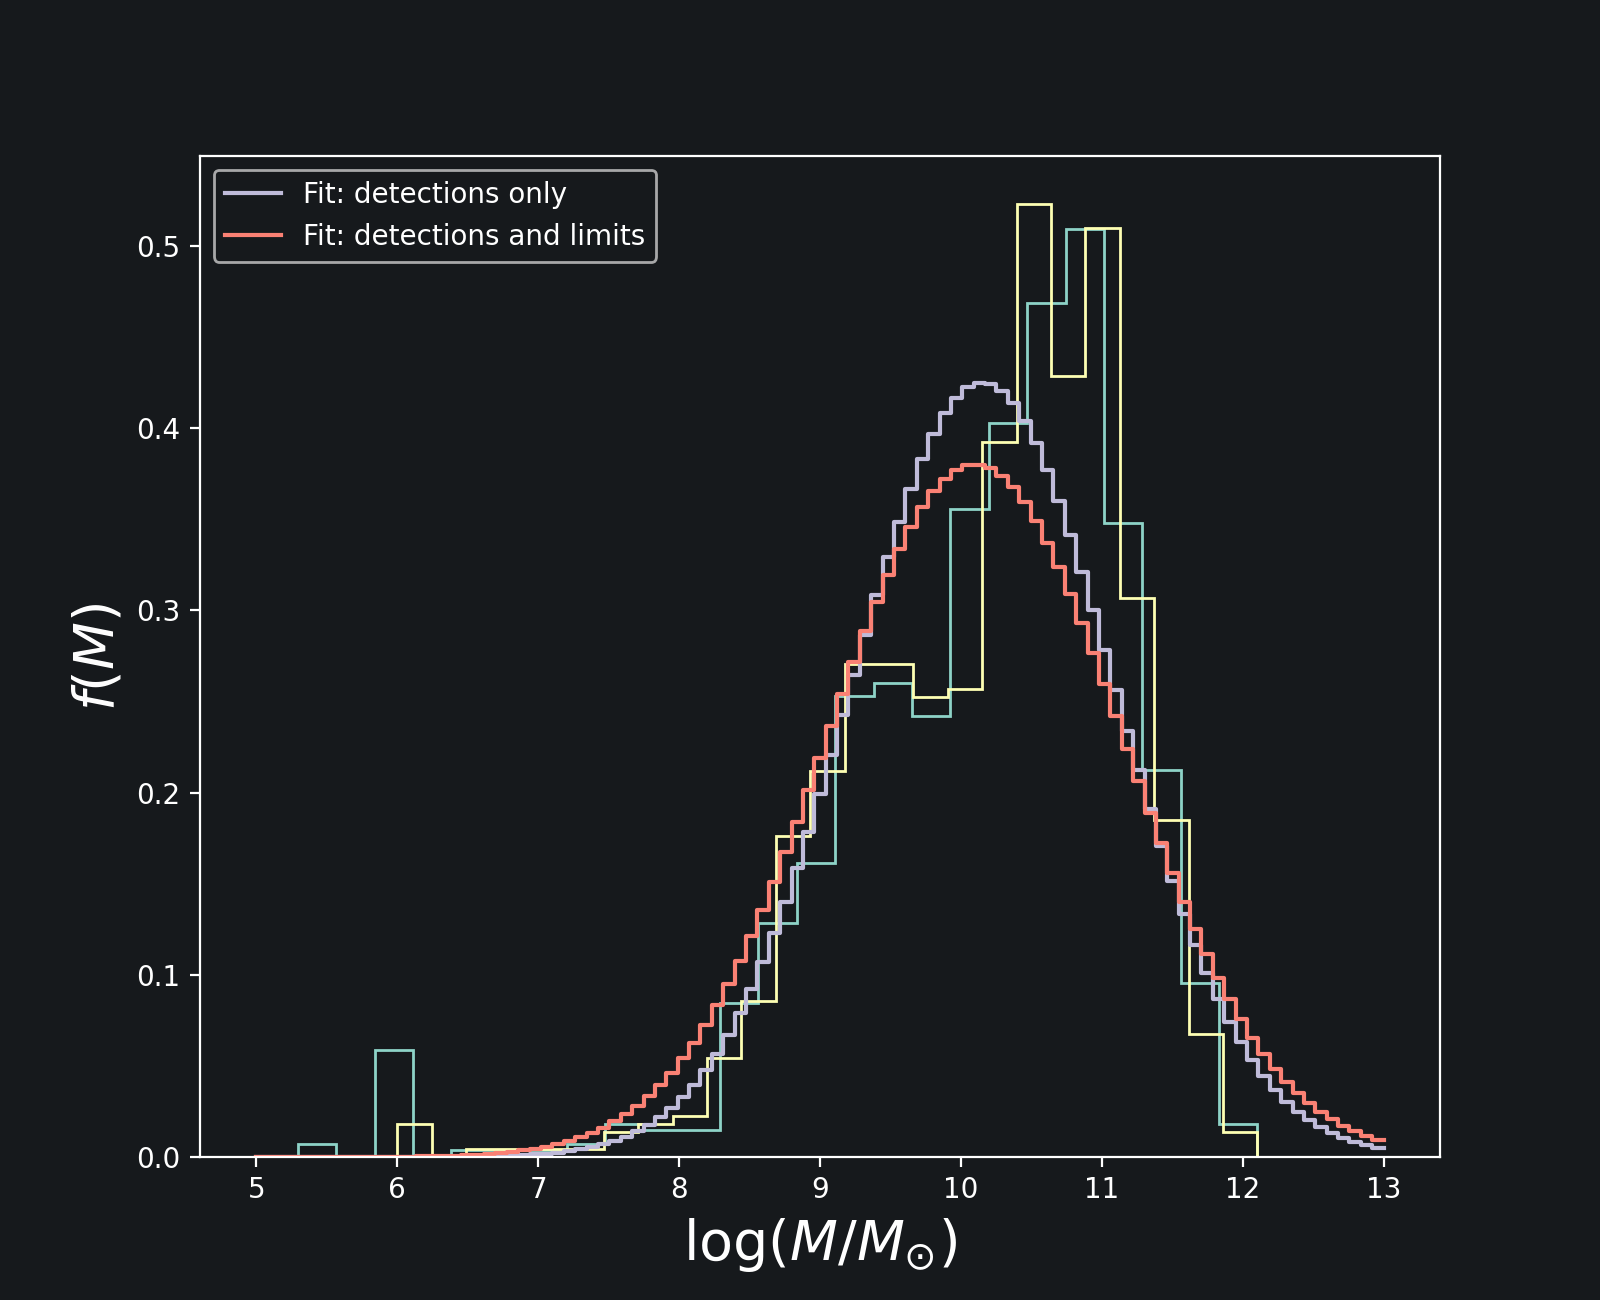

Text(0, 0.5, '$f(M)$')

In [31]:
# Find out the difference between fitted Gaussians if we include detections or not
data = dict(
    N_obs = len(detections),
    y_obs = detections.logm.values,
    )
model =stan_utility.compile_model('stan_models/normal_nolimits.stan')
fit =model.sampling(data=data, seed=1234, iter=int(2000),warmup=1000,n_jobs=4)

chains_nolims = fit.extract()

data = dict(
    N_obs = len(pantheon),
    y_obs = pantheon.logm.values,
    )
model =stan_utility.compile_model('stan_models/normal_nolimits.stan')
fit =model.sampling(data=data, seed=1234, iter=int(2000),warmup=1000,n_jobs=4)
chains_all = fit.extract()



f,ax=plt.subplots(figsize=(8,6.5))
ax.hist(pantheon.logm,density=True,histtype='step',bins=25,label='Data: All values')
ax.hist(detections.logm,density=True,histtype='step',bins=25,label='Data: Detections')
    
ax.set_xlabel('$\log (M/M_{\odot})$',size=20)
ax.set_ylabel('$f(M)$',size=20)


f,ax=plt.subplots(figsize=(8,6.5))
ax.hist(pantheon.logm,density=True,histtype='step',bins=25)
ax.hist(detections.logm,density=True,histtype='step',bins=25)
xs = np.linspace(5,13,100)
ys = stats.norm(np.median(chains_nolims['mu']),np.median(chains_nolims['sigma'])).pdf(xs)
ax.step(xs,ys,label='Fit: detections only')
xs = np.linspace(5,13,100)
ys = stats.norm(np.median(chains_all['mu']),np.median(chains_all['sigma'])).pdf(xs)
ax.step(xs,ys,label='Fit: detections and limits')
ax.legend(loc='upper left')
    
ax.set_xlabel('$\log (M/M_{\odot})$',size=20)
ax.set_ylabel('$f(M)$',size=20)


We can see that the Gaussian doesn't change much no matter if we leave out non-detections. However, the Gaussian is clearly not the best approximation of the data. Let's come back to that.

First, let's factor in that our data has uncertainties. We'll treat each stellar mass detection as a random variable $m_i$, with its _true_ value some location $\mu_i$ and its uncertainty $\sigma_i$.

$m_i \sim \mathcal{N}(\mu_i,\sigma_i)$,

$\mu_i \sim \mathcal{N}(\mu,\sigma)$

In [32]:
# We'll run this on both the full data set, and only the detections
data = dict(
    N_obs = len(detections),
    y_obs = detections.logm.values,
    sigma_obs = detections.logm_err.values,
    )
model =stan_utility.compile_model('stan_models/normal_nolimits_errs.stan')
fit =model.sampling(data=data, seed=1234, iter=int(2000),warmup=1000,n_jobs=4)

chains_normal = fit.extract()



data = dict(
    N_obs = len(pantheon),
    y_obs = pantheon.logm.values,
    sigma_obs = pantheon.logm_err.values,
    )
model =stan_utility.compile_model('stan_models/normal_nolimits_errs.stan')
fit =model.sampling(data=data, seed=1234, iter=int(2000),warmup=1000,n_jobs=4)

chains_all = fit.extract()

    

Using cached StanModel
Using cached StanModel


In [33]:
f,ax=plt.subplots(figsize=(8,6.5))
ax.hist(pantheon.logm,density=True,histtype='step',bins=25)
ax.hist(detections.logm,density=True,histtype='step',bins=25)
xs = np.linspace(5,13,100)
ys = stats.norm(np.median(chains_normal['mu']),np.median(chains_normal['sigma'])).pdf(xs)
xs = np.linspace(5,13,100)
ys = stats.norm(np.median(chains_all['mu']),np.median(chains_all['sigma'])).pdf(xs)
ax.step(xs,ys)
    
ax.set_xlabel('$\log (M/M_{\odot})$',size=20)
ax.set_ylabel('$F(M)$',size=20)


<IPython.core.display.Javascript object>

Text(0, 0.5, '$F(M)$')

Now, we can clearly see that the Gaussian doesn't fit, no matter how we try and take errors into account. Let's do a mixture model, and incorporate the limits like we did before.

We now have a mixture of two Gaussians with parameters $(\mu_1,\sigma_1)$ and $(\mu_2,\sigma_2)$, which are split by a mixing scale $\theta_1+\theta_2 = 1$

Our likelihood is $\pi(y_1,...,y_K| \mu_1,\sigma_1, \mu_2, \sigma_2, \theta_1, \theta_2) = \sum_{k=1}^K \theta_1 \sim \mathcal{N}(y_k|\mu_1,\sigma_1)+ \theta_2 \sim \mathcal{N}(y_k|\mu_2,\sigma_2)$

Where $y_k = (\mu_1,...,\mu_i),(l_1,...,l_j)$

In [ ]:
data = dict(
    N_obs = len(detections),
    N_cens = len(limits),
    y_obs = detections.logm.values,
    y_cens = limits.logm.values,
    y_err = detections.logm_err.values,
    )
model =stan_utility.compile_model('stan_models/normal_survival_mix.stan')
fit =model.sampling(data=data, seed=1234, iter=int(2000),warmup=1000,n_jobs=4)
chains_all_errs = fit.extract()

f,ax=plt.subplots(figsize=(8,6.5))
ax.hist(pantheon.logm,density=True,histtype='step',bins=25,label='All')
ax.hist(detections.logm,density=True,histtype='step',bins=25,label='Detections only')
xs = np.linspace(5,13,100)
#ys = stats.norm(np.median(chains_all['mu1']),np.median(chains_all['sigma1'])).pdf(xs)+stats.norm(np.median(chains_all['mu2']),np.median(chains_all['sigma2'])).pdf(xs)
#ax.step(xs,ys)

all_log_ms = np.concatenate([np.median(chains_all_errs['latent_y_cens'],axis=0).T,detections.logm.values.T])
ax.hist(all_log_ms,density=True,histtype='step',bins=25,label='Imputed')
xs = np.linspace(5,13,100)
bw = ((np.max(xs)-np.min(xs))/100)
ys = np.median(chains_all_errs['theta'])*stats.norm(np.median(chains_all_errs['mu1']),np.median(chains_all_errs['sigma1'])).pdf(xs)+ (1-np.median(chains_all_errs['theta']))*stats.norm(np.median(chains_all_errs['mu2']),np.median(chains_all_errs['sigma2'])).pdf(xs)
ax.step(xs,ys)
ax.legend()

Using cached StanModel


In [ ]:
# Plot the trace to see if our mixture has worked
import arviz as az
az.plot_trace(fit,var_names=['mu1','sigma1','mu2','sigma2','latent_y_cens'],compact=True,)


Now let's do some comparisons between red and blue SNe, and compare to what the Kaplan-Meier estimator gets

In [ ]:
import lifelines

In [ ]:
T = pantheon['logm']
E = pantheon['logm_err'].apply(lambda x: x<2).astype(int)
detections = pantheon[pantheon['logm_err']<2]

from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

kmf.fit_left_censoring(T, E)


In [ ]:
f,ax=plt.subplots(figsize=(8,6.5))
kmf.plot_cumulative_density(label='Kaplan-Meier left_censored',color='g')

sorted_ms,cdf = make_cdf(pantheon['logm'])
ax.step(sorted_ms,cdf,label='All data',color='y')
sorted_ms,cdf = make_cdf(detections['logm'])
ax.step(sorted_ms,cdf,label='Detections only',color='r')
sorted_ms,cdf = make_cdf(all_log_ms)
ax.step(sorted_ms,cdf,label='Detections and imputed limits (Single Gaussian)',color='c')
ax.legend()
ax.set_xlabel('$\log (M/M_{\odot})$',size=20)
ax.set_ylabel('$F(M)$',size=20)
ax.set_xlim(5,12)
plt.tight_layout()


In [ ]:


stretch_cond = pantheon['c']<0
blue_SNe = pantheon[stretch_cond]
red_SNe = pantheon[~stretch_cond]
colours = itertools.cycle(['c','r'])
imputed_data = []
for SNe,sample_name in zip([blue_SNe,red_SNe],['$c <0$','$c\geq0$']):
    f,ax=plt.subplots(figsize=(8,6.5))
    detections = SNe[SNe['logm_err']<2]
    limits = SNe[SNe['logm_err']>2]
    
    c = next(colours)
    data = dict(
        N_obs = len(detections),
        N_cens = len(limits),
        y_obs = detections.logm.values,
        y_cens = limits.logm.values
        )
    
    model =stan_utility.compile_model('stan_models/normal_survival.stan')

    fit =model.sampling(data=data, seed=1234, iter=int(2000),warmup=1000,n_jobs=4)

    chains=fit.extract()

    all_log_ms = np.concatenate([np.mean(chains['latent_y_cens'],axis=0).T,detections.logm.values.T])
    sorted_ms,cdf = make_cdf(detections['logm'])
    ax.step(sorted_ms,cdf,label='%s: Detections only'%sample_name,color='grey')
    sorted_ms,cdf = make_cdf(all_log_ms)
    imputed_data.append([sorted_ms,cdf])
    ax.step(sorted_ms,cdf,label='%s: Detections and imputed limits (Single Gaussian)'%sample_name,color=c)
    ax.legend()
    ax.set_xlabel('$\log (M/M_{\odot})$',size=20)
    ax.set_ylabel('$F(M)$',size=20)
    ax.set_xlim(6.5,12)
    plt.tight_layout()

In [ ]:
f,ax=plt.subplots(figsize=(8,6.5))
for counter,sample_name in enumerate(['$c <0$','$c\geq0$']):
    c = next(colours)
    sorted_ms,cdf = imputed_data[counter]
    ax.step(sorted_ms,cdf,label='%s: Detections and imputed limits (Single Gaussian)'%sample_name,color=c)

for SNe,sample_name in zip([blue_SNe,red_SNe],['$c <0$','$c\geq0$']):
    SNe = SNe[SNe['logm_err']<2]
    sorted_ms,cdf = make_cdf(SNe['logm'])
    c = next(colours)
    ax.step(sorted_ms,cdf,label='%s: Detections Only'%sample_name,color=c,lw=0.5,linestyle='--')
ax.legend()
ax.set_xlabel('$\log (M/M_{\odot})$',size=20)
ax.set_ylabel('$F(M)$',size=20)
ax.set_xlim(6.5,12)
plt.tight_layout()


f,ax=plt.subplots(figsize=(8,6.5))
for counter,sample_name in enumerate(['$c <0$','$c\geq0$']):
    c = next(colours)
    
    ax.hist(imputed_data[counter][0],label='%s: Detections and imputed limits (Single Gaussian)'%sample_name,color=c,histtype='step',density=True,bins=25)

for SNe,sample_name in zip([blue_SNe,red_SNe],['$c <0$','$c\geq0$']):
    SNe = SNe[SNe['logm_err']<2]
    
    c = next(colours)
    ax.hist(SNe['logm'],label='%s: Detections Only'%sample_name,color=c,lw=0.5,linestyle='--',histtype='step',density=True,bins=25)
ax.legend(loc='upper left')
ax.set_xlabel('$\log (M/M_{\odot})$',size=20)
ax.set_ylabel('$f(M)$',size=20)
ax.set_xlim(5,12.5)
#ax.set_ylim(0,0.7)
plt.tight_layout()


In [ ]:
pantheon = pantheon[pantheon['logm']>6.1]
stretch_cond = pantheon['c']<0
blue_SNe = pantheon[stretch_cond]
red_SNe = pantheon[~stretch_cond]
colours = itertools.cycle(['c','r'])
imputed_data = []
fit_params = []

for SNe,sample_name in zip([blue_SNe,red_SNe],['$c <0$','$c\geq0$']):
    f,ax=plt.subplots(figsize=(8,6.5))
    detections = SNe[SNe['logm_err']<2]
    limits = SNe[SNe['logm_err']>2]
    
    c = next(colours)
    data = dict(
        N_obs = len(detections),
        N_cens = len(limits),
        y_obs = detections.logm.values,
        y_cens = limits.logm.values,
        y_err = detections.logm_err.values,
        )
    model =stan_utility.compile_model('stan_models/normal_survival_mix.stan')
    fit =model.sampling(data=data, seed=1234, iter=int(2000),warmup=1000,n_jobs=4)
    chains_all_errs = fit.extract()

    all_log_ms = np.concatenate([chains_all_errs['latent_y_cens'].T,chains_all_errs['latent_y'].T])
    sorted_ms,cdf = make_cdf(detections['logm'])
    ax.step(sorted_ms,cdf,label='%s: Detections only'%sample_name,color='grey')
    sorted_ms,cdf = make_cdf(np.mean(all_log_ms,axis=1))
    imputed_data.append([all_log_ms,sorted_ms,cdf])
    fit_params.append([chains_all_errs['mu1'],chains_all_errs['mu2'],chains_all_errs['sigma1'],chains_all_errs['sigma2'],chains_all_errs['theta']])
    ax.step(sorted_ms,cdf,label='%s: Detections and imputed limits (Gaussian Mixture)'%sample_name,color=c)
    
    T = detections['logm']
    E = detections['logm_err'].apply(lambda x: x<2).astype(int)
    

    from lifelines import KaplanMeierFitter
    kmf = KaplanMeierFitter()

    kmf.fit_left_censoring(T, E)
    kmf.plot_cumulative_density(label='Kaplan-Meier left_censored',color='m')
    ax.legend()
    ax.set_xlabel('$\log (M/M_{\odot})$',size=20)
    ax.set_ylabel('$F(M)$',size=20)
    ax.set_xlim(5,12)
    plt.tight_layout()



In [ ]:

data = az.from_pystan(fit)


In [ ]:
az.plot_trace(data,var_names=['mu1','sigma1','mu2','sigma2','latent_y_cens'],compact=True,)
az.plot_joint(data,var_names=['mu1','mu2',],kind='kde',)

In [ ]:
colours = itertools.cycle(['c','r'])
f,ax=plt.subplots(figsize=(8,6.5))
for counter,sample_name in enumerate(['$c <0$','$c\geq0$']):
    c = next(colours)
    all_imputed = imputed_data[counter][0]
    for i in range(len(all_imputed)):
        label=None
        if i ==0:
            label='Imputed %s'%sample_name
        sorted_ms,cdf = make_cdf(all_imputed[:,i])
        ax.step(sorted_ms,cdf,linewidth=0.05,color=c,alpha=0.2,label=label)
for SNe,sample_name in zip([blue_SNe,red_SNe],['$c <0$','$c\geq0$']):
    SNe = SNe[SNe['logm_err']<2]
    
    c = next(colours)
    sorted_ms,cdf = make_cdf(SNe['logm'])
    ax.step(sorted_ms,cdf,label='%s: Detections only'%sample_name,color=c,linestyle='--')
    
    T = SNe['logm']
    E = SNe['logm_err'].apply(lambda x: x<2).astype(int)
    

    from lifelines import KaplanMeierFitter
    kmf = KaplanMeierFitter()

    kmf.fit_left_censoring(T, E)
    kmf.plot_cumulative_density(label='Kaplan-Meier left_censored',color=c,ci_show=False,linestyle=':')
leg =ax.legend(loc='upper left')
for lh in leg.legendHandles:
    lh.set_alpha(1)
    lh.set_linewidth(1)
ax.set_xlabel('$\log (M/M_{\odot})$',size=20)
ax.set_ylabel('$F(M)$',size=20)
ax.set_xlim(6.5,12)
#ax.set_ylim(0,0.7)
plt.tight_layout()


In [ ]:

f,ax=plt.subplots(figsize=(8,6.5))
for counter,sample_name in enumerate(['$c <0$','$c\geq0$']):
    c = next(colours)
    params = fit_params[counter]
    
    mu1,mu2,sigma1,sigma2,theta = [params[i] for i in range(len(params))]
    
    #ax.hist(imputed_data[counter][0],label='%s: Detections and imputed limits (Gaussian Mixture)'%sample_name,color=c*4000,histtype='step',density=True,bins=25)
    xs = np.linspace(5,13,1000)
    bw = ((np.max(xs)-np.min(xs))/100)
    for j in range(len(mu1)):
        label=None
        if j ==0:
            label='Imputed %s'%sample_name
        ys = theta[j]*stats.norm(mu1[j],sigma1[j]).pdf(xs)+ ((1-theta[j])*stats.norm(mu2[j],sigma2[j]).pdf(xs))
        ax.step(xs,ys,linewidth=0.05,c=c,alpha=0.1,label=label)
for SNe,sample_name in zip([blue_SNe,red_SNe],['$c <0$','$c\geq0$']):
    SNe = SNe[SNe['logm_err']<2]
    
    c = next(colours)
    #ax.hist(SNe['logm'],label='%s: Detections Only'%sample_name,color=c,linestyle='--',histtype='step',density=True,bins=25,)
    plot_hist(SNe['logm'],SNe['logm'].min(),SNe['logm'].max(),0.25,axhist=ax,label='%s: Detections Only'%sample_name,color=c,linestyle='--',density=True)

ax.set_xlabel('$\log (M/M_{\odot})$',size=20)
ax.set_ylabel('$f(M)$',size=20)
ax.set_xlim(6.5,12.)
#ax.set_ylim(0,0.7)
plt.tight_layout()
leg =ax.legend(loc='upper left')
for lh in leg.legendHandles:
    lh.set_alpha(1)
    lh.set_linewidth(1)
